# Hands-on example: mapping blood flow changes after MCAO (laser speckle data)

## Goals:
  - load MLF data
  - crop the area of interest and save as another sequence
  - make a movie
  - display overall CBF dynamics with time
  - calculate relative changes in blood flow
  - map these relative changes and look for peri-ischaemic zones
  - make nice plots in the process

First, we need to load importand modules and set up some display details:

In [1]:
%pylab qt
style.use('ggplot')
# This is just a custom plot style

from scipy import ndimage

import pandas as pd

import os.path

from imfun import fseq, lib, ui
rcParams['image.aspect']='equal'
rcParams['image.origin']='upper'
rcParams['figure.facecolor']='w'

from matplotlib import animation
#reload(animation)
animation.writers.list()

from imfun import filt

from matplotlib import rc


def minute2ind(arr, dt):
    "for array (e.g. tranges) in minutes, return frame indices, assuming dt is in seconds"
    #for i in range(len(arr)):   
    return (arr*60/dt).astype(np.int)

def sec2ind(arr, dt):
    "for array (e.g. tranges) in sec, return frame indices, assuming dt is in seconds"
    #for i in range(len(arr)):   
    return (arr/dt).astype(np.int)

def minsec2mindec(arr):
    "for time in format min.sec, return min.dec eg. 2.30 = 2.50"
    return (int(arr) + ((arr % 1) / 0.6))

def ind2sec(arr, dt):
    "for array (e.g. tranges) in frame indices, return seconds, assuming dt is in seconds"
    return (arr*dt)

def ind2min(arr, dt):
    "for array (e.g. tranges) in frame indices, return minutes, assuming dt is in seconds"
    return int(arr * dt / 60)

def satisfies_keys(field, keys):
    """for each key check whether string `field` contains this key 
    if key is a string or any variants of the key if the key is a collection of strings"""
    res = True
    for key in keys:
        if isinstance(key, basestring):
            tmp = key in field
        else:
            tmp = np.any([(variant in field) for variant in key])
        res = res and tmp
        if not res: break
    return res

def smart_filter_columns(table, keys):
    if isinstance(table, pd.Series):
        index = table.index
    elif isinstance(table, pd.DataFrame):
        index = table.columns
    else:
        raise TypeError("Wrong table format") 
    cols = [c for c in index if satisfies_keys(c, keys)]
    return cols
            
#merge reps

def get_average_of_rep(serie):
    """find repeated stimulations in a pd.serie and return a serie 
    contaning the average of theese stimulations """
    roi_all = unique([c.split(':')[-1].strip() for c in x.columns])#['r01', 'r02', 'r03']
    freq_all = sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0])) #['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
    epo_all = unique([c.split(':')[0].strip() for c in x.columns]) #['epo1', 'epo2', 'epo3', 'epo4']
    average_results = pd.Series()    
    for roi in roi_all:
        for freq in freq_all:
            for epo in epo_all:
                test_rep = smart_filter_columns(serie, [roi, freq, epo])
                rep_n = len(test_rep)
                average = serie[test_rep].mean(axis=None, skipna=None, level=None, numeric_only=None)
                average_results[' : '.join((epo, freq, roi, 'rep_n=%d'%rep_n))] = average
    return average_results

def pixels2mm2(areas, pixel_size):
    "take a list of areas in number of pixels and converts them to mm^2"
    areas_mm2 = []
    for i in range(len(areas)):
        areas_mm2.append((np.sum(areas[i]) * (pixel_size ** 2)) / 1000000)
    return areas_mm2

def area_in_pixels(tranges, dt, level_of_interest):
    """take a list of frame sequenses(minutes), time between frames(s) and a tuple with the level of interest(%). 
    it returns a list of areas in pixels"""
    changes_after = []
    areas = []
    for i in range(len(tranges)):
        changes_after.append(fs2.mean_frame(minute2ind(tranges[i], dt)))
    for i in range(len(changes_after)):
        areas.append((level_of_interest[0] < changes_after[i]) * (changes_after[i] < level_of_interest[1]))
    return areas

def montage(ims, ncols, mask=None, **kwargs):
    style.use('ggplot')
    sh = ims[0].shape
    nrows = int(np.ceil(len(ims)/float(ncols)))
    out_shape = nrows*sh[0],ncols*sh[1]
    out = np.zeros(out_shape)
    if mask is not None:
        out_mask = np.zeros(out_shape, np.bool)

    imrows, imcols = sh
    
    
    for k, m in enumerate(ims):
        row_i,col_i = imrows*(k/ncols), imcols*(k%ncols)
        _slice = (slice(row_i,row_i+imrows), slice(col_i,col_i+imcols))
        out[_slice] = m
        if mask is not None:
            if np.ndim(mask) > 2 and k < len(mask):
                out_mask[_slice] = mask[k]
            else:
                out_mask[_slice] = mask
    if mask is not None:
        out = ma.masked_where(out_mask, out)        
    imshow(out, **kwargs)
    [axvline(x, color='white') for x in range(imcols,out_shape[1], imcols)]
    [axhline(x, color='white') for x in range(imrows,out_shape[0], imrows)]
    r = Rectangle((0,0), 10, 1e3/pixel_size, color='yellow')
    gca().add_patch(r)
    setp(gca(), xticks=[],yticks=[],frame_on=False)
    tight_layout()
    return out

def extract_roi_data():
    agg = []
    stim_freqs = epochs[0]
    print stim_freqs
    tvec = arange(-baseline_horizon, afterstim_horizon)
    for epnum,epoch in enumerate(epochs[1:]):
        for repnum, rep in enumerate(epoch):
            for t0,freq in zip(rep, stim_freqs):
                print t0,freq
                arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
                fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence
                p3 = ui.Picker(fs3_cut, verbose=False)
                p3.start()
                p3.load_rois(data_path+ '041-funcmap-rois_mm.pickle')
                data = 100*array(p3.get_timeseries(normp=baseline_horizon))
                headers = [' : '.join(('epo%d'%(epnum+1), 'rep%d'%(repnum+1) ,'%dHz'%freq, tag)) for tag in p3.roi_tags()]
                x = pd.DataFrame({name:v for name,v in zip(headers, fs3)}, index=tvec)
                agg.append(x)
                close()
    return agg


Populating the interactive namespace from numpy and matplotlib
Can't load OpenCV python bindings No module named cv2


## Step 0. Load the data (run always)


<font color='red'>Choose your path to the data.

This way you read the file names with system (non-python) `ls` command and convert it to a python variable

In [2]:
#data_path = '/home/data/MLauritzen-group/data-for-seminar/'
data_path = '/Users/cfw958/Desktop/lsi/091/'

#data_path = 'smb://sundcifs12.sund.root.ku.dk/INF/NEUROFYSIOLOGI/TransNeuro/Jonas C. Fordsmann/Data pHd/Live Image Measurement-m125a-JCF-2015.mlf'
# at the moment, I have the data in Dropbox right here
#data_path = './'

#files = !ls /Users/cfw958/Desktop/lsi/*125.mlf
x = data_path.replace(' ', '\ ') # This thing you have to do if the data path has whitespaces
files = !ls {x +'*091*.mlf'} # this is equivalent to the above


<font color='red'>
  - Set ruler size in mm

  - The variable called 'of' (occlusion file) is the file number where you do the occlusion

  - put the number of files you want to merge (k=0 means 1 file)
  
  - Change the name so that it coresponde to the animal number
  
  - If you dont want the Improwed Lasso set improve_lasso to True
  
  - set limits for healthy, penumbra and core  as procentage of baseline before intervention (e.g. from 2o% to 50% of baseline would be (20, 50)


In [3]:
ruler_size = 3.55 # ruler size in mm (ruler  1 mm and gap between cranie edge where the gluebridge is = 3.55 mm) 
of = 1 #Select the occlusion file (2nd, with 'b')
k = 3
improve_lasso = False
name_cropped = '091-cropped.h5'
healthy = (50, 2000)
penumbra = (20, 50)
core = (0, 20)
crop_frame = True

In [4]:
name = files[of]
print 'occlusion file: ', name

# Create frame sequence objects from a list for file names 
fslist = [fseq.open_seq(name) for name in files]
dt, units = fslist[0].meta['axes'][0]
frame_rate = float(fslist[0].meta.get('axes')[0][0])
print 'frame rate = ' + str(frame_rate) + ' FPS'

occlusion file:  /Users/cfw958/Desktop/lsi/091/Live Image Measurement091b.mlf
frame rate = 1.0 FPS


<font color='red'>1) while cursor is over figure, press Shift to enable Lasso selector and right click and then rigth click and hold to draw around the area of interst
2) Draw line Roi

In [5]:
# Calculate average frame over first 60 seconds
mf = fslist[of].mean_frame(minute2ind(1, dt)) # First minute average

# Create a UI object and start it
p = ui.Picker(fslist[of]) #if you set a argument verbose = True inside brackets a manual get printet
p.start(mean_frame=mf, cmap='hot',vmax=1000) # I clip the values above 1000 for better vis.

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x10477cd10>,
 <imfun.ui.Picker instance at 0x10429d7e8>)

<font color='red'>If done before use the pixel_size according to output of this cell

In [6]:
# gets the length of a line roi put in a known distance to calculate pixel size

lengths = [r.length() for tag,r in p.roi_objs.items() if p.isLineROI(tag)]
#lengths_as_dict = {tag:r.length() for tag,r in p.roi_objs.items() if p.isLineROI(tag)}
#lengths_as_dict

#pixel_size = (ruler_size * 1000) / float(lengths[0]) # pixel size in um
# If done before use the following line to set pixel size according to output of this cell
pixel_size = 14.2352595936
print 'ruler length = ' + str(lengths) + ' pixels'
print 'pixel size = ' + str(pixel_size) + ' um'

249.38
ruler length = [249.38077009845398] pixels
pixel size = 14.2352595936 um


/Users/cfw958/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/cfw958/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


# Step 1. Cropping

<font color='red'>**If you already cropped the frame and saved the concatenated-and-cropped frame sequence, skip this and proceed to Step2**

In [7]:
if crop_frame:
    savefig(data_path + 'raw_figure.pdf') #alternatively .png .svg . eps
    gcf()

We can continue with it, but we can also try to improve this a little bit with active contours:

In [8]:
# Import morphsnakes module if it's installed, install and import it otherwise
if crop_frame:
    if improve_lasso:
        try:
            import morphsnakes
        except ImportError:
            print "Don't have morphsnakes, installing"
            !pip install https://github.com/abrazhe/morphsnakes/zipball/master
            import morphsnakes

In [9]:
if crop_frame:
    if improve_lasso:
        reload(morphsnakes)
        figure()
        snake = morphsnakes.MorphACWE(mf,smoothing=3, lambda2=1.5, levelset=p.pmask)
        snake.run(50) # Run 50 or less iterations of MACWE algorithm

        imshow(mf, cmap='gray',vmax=1000); colorbar()
        contour(p.pmask, levels=[0],  colors=['g']) # starting contour
        contour(snake.levelset, levels=[0],  colors=['r']) # end contour
        savefig(data_path + 'Improved lasso crop.pdf')
        gcf()

**Exercise**: change number of iterations and values for `smoothing`, `lambda1`, and `lambda2` arguments and see what happens.

## Clip the data
Simple solution (no need to load all data to memory), also demonstrates why fseq.fns is there: 

Too much white, eh? On the brigth side, we don't have to load all the frames to do this.

It seems better to through away all unnecessary data and save the cropped sequence to an HDF5 format, so working with it later will be faster:

Help on function embedding in module imfun.lib:

embedding(arr, delarrp=True)
    Return an *embeding* of the non-zero portion of an array.
    
    Parameters:
      - `arr`: array
      - `delarrp`: predicate whether to delete the `arr`
    
    Returns tuple ``(out, (sh, slices))`` of:
        * out: array, which is a bounding box around non-zero elements of an input
          array
        * sh:  full shape of the input data
        * slices: a list of slices which define the bounding box

None
True


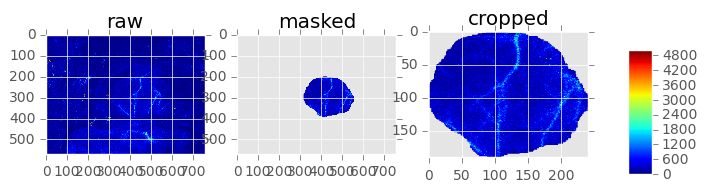

In [10]:
if crop_frame:
    print help(lib.embedding)
    fs = fslist[of]

    #pmask = snake.levelset # Comment this line if you didn't do the snakes
    pmask = p.pmask # Uncomment this if you didn't do the snakes

    func = lambda f: ma.masked_where(pmask == 0, f*pmask)

    f = fs[10] # take 11th frame from frame sequence
    lib.group_maps([f, func(f), lib.embedding(func(f))[0]], 
               titles=['raw', 'masked', 'cropped'],
               show_ticks = True)
    savefig(data_path + 'raw, masked, cropped.pdf')
gcf()

Cropping box: [slice(201, 391, None), slice(316, 557, None)]
(190, 241) (190, 241)


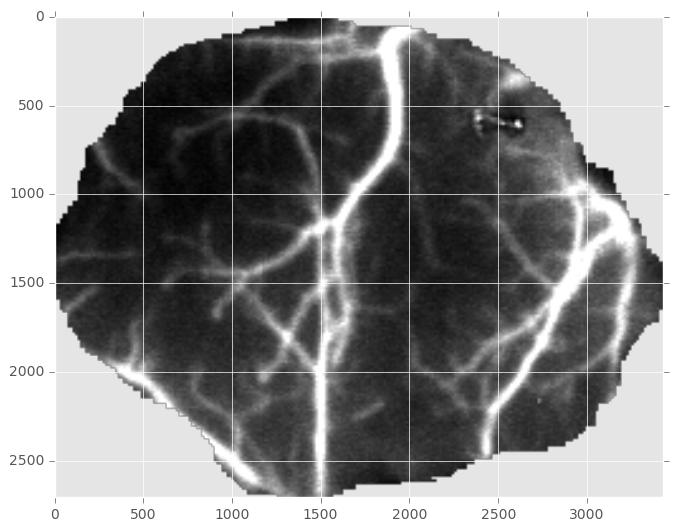

In [11]:
# we have to do embedding on the pmask, not each frame, to ensure the shape doesn't change
if crop_frame:
    _,(_,crop) = lib.embedding(pmask)

    print 'Cropping box:', crop

    fs = fslist[of]
    fs.fns = [lambda f: ma.masked_where(pmask==0, f*pmask), 
          lambda f: f[crop]]

    figure(10)
    imshow(fs.pipeline()(mf), vmax=1000,cmap='gray', extent = [0, (pixel_size * fs.shape()[1]), (pixel_size * fs.shape()[0]), 0])
    
    print fs[minute2ind(1, dt)].shape, fs.shape()
    savefig(data_path + 'cropping box.pdf')
gcf()

Apply the same processing pipline (a list of two functions applied to each frame in a sequence) to all loaded frame sequences (mlf files from the current experiment)

In [12]:
if crop_frame:
    pipeline = [lambda f: ma.masked_where(pmask==0, f*pmask), 
              lambda f: f[crop]]

    for seq in fslist:
        seq.fns = pipeline

In [13]:
# check that the pipeline makes sense for other frame sequences
if crop_frame:
    ui.Picker(fslist[k]).start(mean_frame=fslist[k].mean_frame(minute2ind(1, dt)), cmap='hot', vmax=1000,vmin=0)

connecting callbacks to picker


In [14]:
if crop_frame:
    reload(fseq)

Can't load OpenCV python bindings No module named cv2


This is the actual conversion function. It returns a name of the new file. May be it would be better if it returned the new sequence instead?

In [16]:
if crop_frame:
    name2 = fseq.fseq2h5(fslist, data_path + name_cropped)
    print name2

shape: [190 241]
/Users/cfw958/Desktop/lsi/091/091-cropped.h5


# Step 2. Resting CBF

Note you have to create a variable called name2 with the name of the processed frame sequence (the one that end with '.h5')

Let's check that everything worked as expected, if the sequences are not aligned: one sees a double-image. This proves that the camera sadly have been moved during the recordings

In [17]:
x = data_path.replace(' ', '\ ') # This thing you have to do if the data path has whitespaces
name2 = !ls {x + '*.h5'} 
print name2
fs2 = fseq.open_seq(name2[0])
fs2.meta

fs2.meta['axes'] = lib.alist_to_scale([(frame_rate, 's'), 
                                       (pixel_size, 'um'),
                                       (pixel_size, 'um')])

print fs2.meta
print fs2.shape()

['/Users/cfw958/Desktop/lsi/091/091-cropped.h5']
The file /Users/cfw958/Desktop/lsi/091/091-cropped.h5 has the following data sets: [u'data']
{'axes': array([(1.0, 's'), (14.235259593586475, 'um'), (14.235259593586475, 'um')], 
      dtype=[('scale', '<f8'), ('units', 'S10')])}
(190, 241)


connecting callbacks to picker


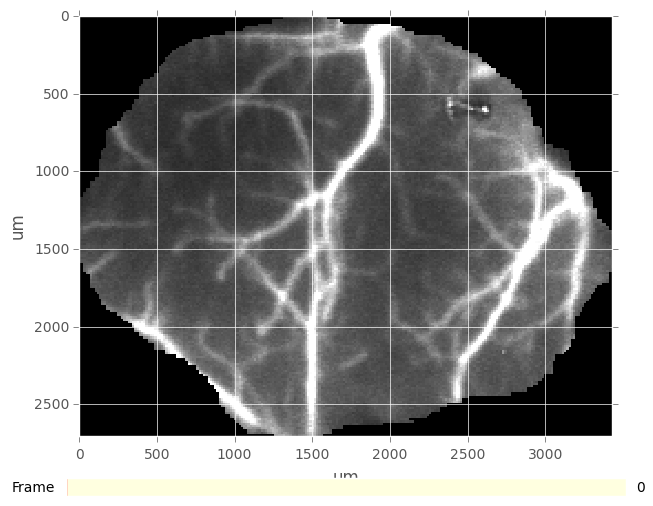

In [19]:
if len(fslist) > 1:   
    skip = len(fslist) and len(fslist[0]) or 0
    mf2 = fs2.mean_frame((skip, skip + minute2ind(1, dt)))
    p2 = ui.Picker(fs2); p2.start(mean_frame=mf2, cmap='gray',vmin=0, vmax=1000)    
else:
    print "There is nothing to merge"
gcf()

## Overall CBF dynamics

Small problem is, without going through the data, I don't know when MCAO was performed, so what to take as baseline and what time intervals to use for mapping. Let's find out by plotting interquartile range and the median of pixel intensities over time:

In [94]:
# Note I use list comprehesions all the time
fs2.fns = []
v = np.array([np.percentile(f[f>0], (25,50,75)) for f in fs2.frames()])

In [95]:
close('all')

Fsborders is: [3310, 6659, 8922, 11344]


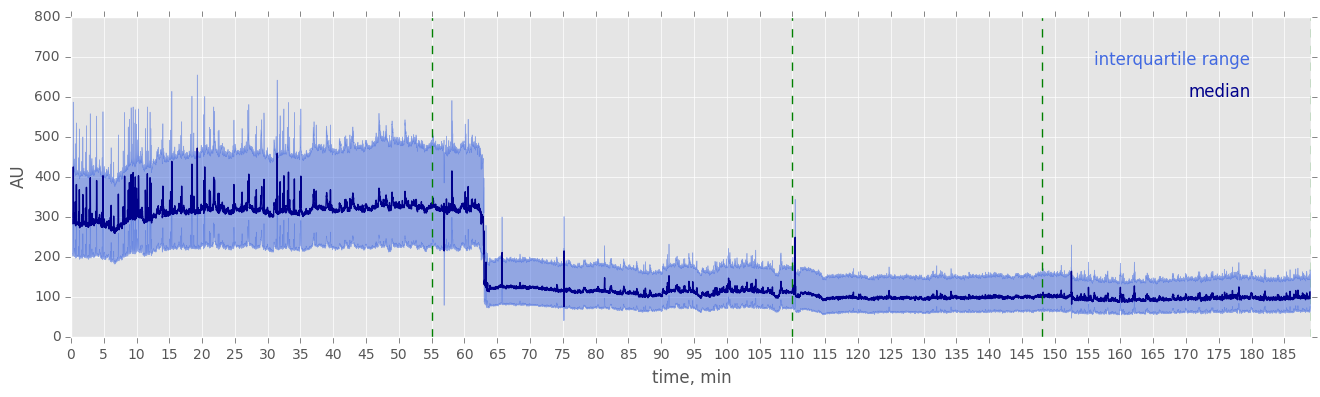

In [96]:
# time in minutes. If framerate is correctly set in fs2.meta, then
# fs2.frame_idx() returns time in seconds, we divide by 60 to convert to minutes
# if fs2.meta is not set, then frame_idx implies framerate is 1 Hz. This may be a problem
# if the framerate was different from 1 Hz.
t = fs2.frame_idx()/minute2ind(1, dt)

# borders between files
### 
#fsborders = cumsum([len(fs) for fs in fslist]) #Run this if LSI files, if .h5 use next line with known values
fsborders = [3310, 6659, 8922, 11344]
print 'Fsborders is:', fsborders

figure(figsize=(16,4)) # we want a looong figure

# fill_between -- well, to make a fill-between-two-lines-plot
fill_between(t, v[:,0], v[:,2], color='royalblue', alpha=0.5)

# and this is the median
plot(t,v[:,1], color='darkblue')

# put a green line at the merge points between the original files
for b in fsborders:
    axvline(b / minute2ind(1, dt), color='green', ls='--')

# Set x ticks to go every minute and limits for x axis
# gca() is the command to get the currently active axis
setp(gca(), xlim=(0, t[-1]), ylim=(0,800), xticks=arange(0,t[-1], 5)) # put ticks every 5 minutes

txt_par = dict(fontsize='large', horizontalalignment='right', transform=gca().transAxes)

text(0.95, 0.85, 'interquartile range', color='royalblue',**txt_par)
text(0.95, 0.75, 'median', color='darkblue', **txt_par)

xlabel('time, min',fontsize='large')
ylabel('AU',fontsize='large')

gcf()

**TODO**: add an interactive range picker

In [97]:
#description from log file
"""
Made craniotomy(bloody), placed LFP good responses. (slidely more medial)
Swicht alfa
Took a good blood gas. 

LSI
Strange activity involving full hemisphere
First stim at 24.50 in LSI file a (spike file a at 35:55)
LSI gave Good responses

started LSI file b in spike file a at 01:06:24 
Made MCAO el at 6.30 and occluded at 07.50 in LSI file b followed by bleading and csf

Perfect occlusion, nealy no medial penumba
Decresed spontaneous activity in penumbra

PID at ca 13.50 in medial rois in LSI file b 

Stim at 23.00 in LSI file b( (lateral rois Attenuated) CBF responses) BP response

started LSI file c in spike file a at 2:02:20 


LSI file d start at 2:46:22

Stim at 07.10 in LSI file d((very Attenuated CBF responses)
"""

'\nMade craniotomy(bloody), placed LFP good responses. (slidely more medial)\nSwicht alfa\nTook a good blood gas. \n\nLSI\nStrange activity involving full hemisphere\nFirst stim at 24.50 in LSI file a (spike file a at 35:55)\nLSI gave Good responses\n\nstarted LSI file b in spike file a at 01:06:24 \nMade MCAO el at 6.30 and occluded at 07.50 in LSI file b followed by bleading and csf\n\nPerfect occlusion, nealy no medial penumba\nDecresed spontaneous activity in penumbra\n\nPID at ca 13.50 in medial rois in LSI file b \n\nStim at 23.00 in LSI file b( (lateral rois Attenuated) CBF responses) BP response\n\nstarted LSI file c in spike file a at 2:02:20 \n\n\nLSI file d start at 2:46:22\n\nStim at 07.10 in LSI file d((very Attenuated CBF responses)\n'

<font color='red'> 
Here you should put;
 - Occlusion time in minutes and sec(e.g. 3min 30sec = 3.30)
 - Baseline of 2 min and intervals of 2 min that you want to analyse. Format (1, 3) means from first min to third min of movie.
 - You can use fsboarder if useful. Remember to avoid stimulations.

In [98]:
#occlusion_time_input = 16.45 # occlusion time in format min.sec (if more movies are merged you can use fsboarders)
occlusion_time= ind2min(fsborders[0], dt) + minsec2mindec(07.50) #if more movies are merged you can use fsboarders stil in format min.sec

#translate occlusion time to decimal
#occlusion_time = minsec2mindec(occlusion_time_input)#int(occlusion_time_input) + ((occlusion_time_input % 1) / 0.60) # occlusion time in minutes (decimal), dont change

#set tranges
#before_stim = (1, 3)
baseline = (54, 56)#(fsborders[0]/60.-2, fsborders[0]/60.+0) # # min 
interval_1 = (66, 68) #(occlusion_time + 0, occlusion_time + 2)#(occlusion_time, occlusion_time + 2) # min
interval_2 = (111, 113) #(occlusion_time + 8, occlusion_time + 10)#(fsborders[1]/60.-2, fsborders[1]/60.+0) #(occlusion_time + 8, occlusion_time + 10) #min
interval_3 = (140, 142) #(fsborders[2]/60.-2, fsborders[2]/60.+0) #(fsborders[1]/60.+11, fsborders[1]/60.+13) # min
interval_4 = (187, 189) #((ind2min(fsborders[2], dt) + minsec2mindec(05.00)), (ind2min(fsborders[2], dt) + minsec2mindec(07.00)))

#makes array of tranges (dont change)
tranges_min = np.array([baseline, interval_1, interval_2, interval_3, interval_4])
tranges_ind = minute2ind(tranges_min, dt)
#reperfusion_time = 42.63

step 2 basic ends here

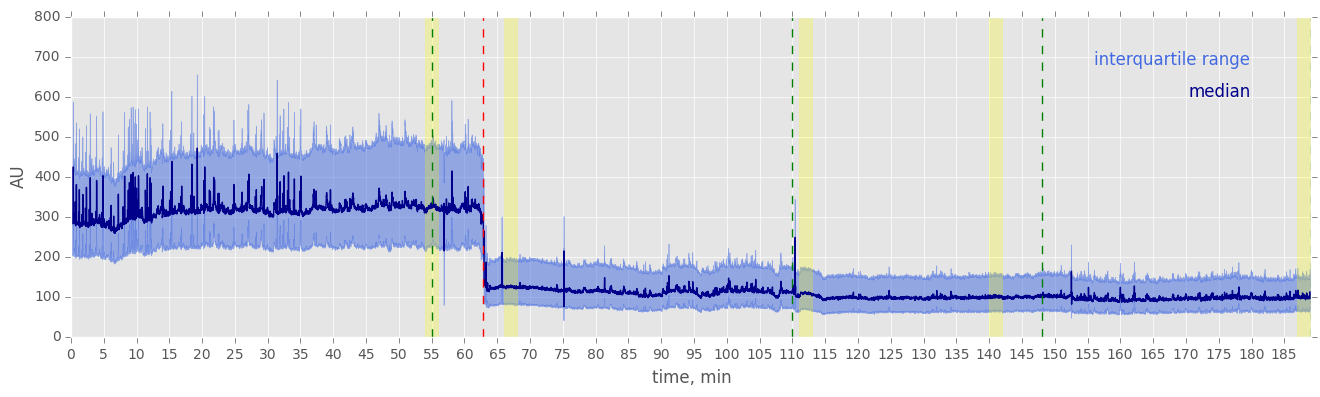

In [99]:
#mark occlusion time
axvline(occlusion_time,  color='r', ls='--')
#axvline(reperfusion_time,  color='r', ls='--')

# Show them on the graph:
for r in tranges_min:
    axvspan(*r, alpha=0.25, color='yellow')

draw()
gcf()

In [100]:
base_frame = fs2.mean_frame(tranges_ind[0]) # time-averaged frame over first of tranges

### <font color='blue'>Could be nice to be able to make a movie where 'no changes' shown as grey scale and changes above SD or 10 % shown as color scale)

Create a demonstration movie from the new frame sequence:
<font color='red'> 
Here you should put;
 - movie name
 - movie start
 - movie stop
 - set make movie to true if you want to make the movie
    

In [101]:
movie_name = '091-PID x20.mp4'
movie_start = 65 #time in minutes
movie_stop = 75 #time in minutes
fps = 20
make_movie = True

Don't run the following so far, as your system lacks `mencoder` or `avconv` and will instead try to create 8K images in your current folder.

In [63]:
if make_movie:
    fs2.export_movie_anim(data_path + movie_name, fig_size=(6,8), fps=fps, start = minute2ind(movie_start, dt), 
                          stop = minute2ind(movie_stop, dt), writer='ffmpeg', 
                          codec='h264',
                          cmap='jet',
                          vmin=0,vmax=1000)

## Calculate normalized CBF values in a lazy way

In [102]:
fs2.fns = [lambda f: np.where(base_frame>0, (100.*f)/base_frame, 0), 
           lambda f: ma.masked_where(base_frame <= 0, f)]
v = np.array([np.percentile(f[f>0], (25,50,75)) for f in fs2.frames()])

Now, show the new data:

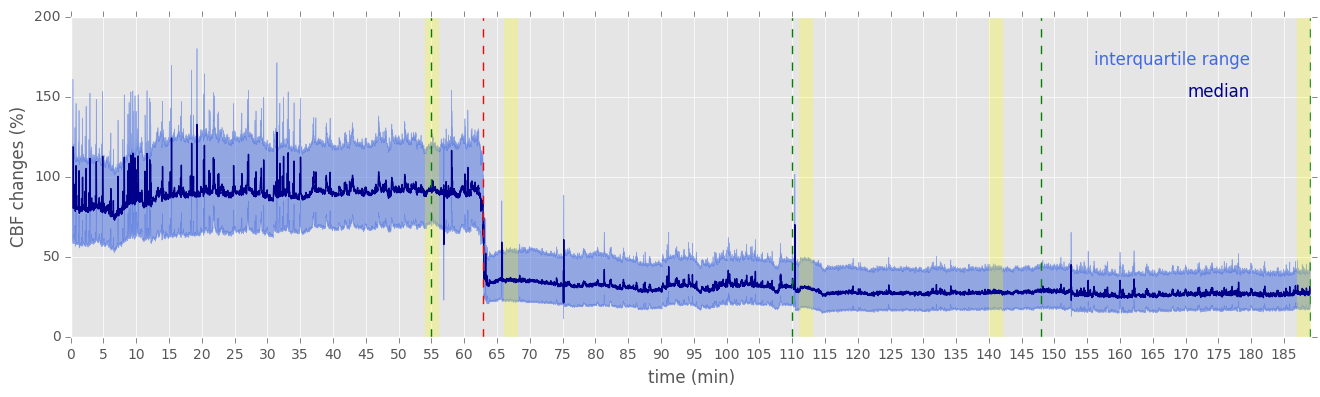

In [103]:
fig_handle = figure(figsize=(16,4)) # we want a looong figure

# fill_between -- well, to make a fill-between-two-lines-plot
fill_between(t, v[:,0], v[:,2], color='royalblue', alpha=0.5)

# and this is the median
plot(t,v[:,1], color='darkblue')

# average
#plot(t, frame_average, color = 'deeppink')

# put a green line at the merge points between the original files
for b in fsborders:
    axvline(b / minute2ind(1, dt), color='green', ls='--')

# Set x ticks to go every minute and limits for x axis
# gca() is the command to get the currently active axis
setp(gca(), xlim=(0, t[-1]), ylim=(0,200), xticks=arange(0,t[-1], 5)) # put ticks every 5 minutes

txt_par = dict(fontsize='large', horizontalalignment='right', transform=gca().transAxes)

text(0.95, 0.85, 'interquartile range', color='royalblue',**txt_par)
text(0.95, 0.75, 'median', color='darkblue', **txt_par)

xlabel('time (min)',fontsize='large')
ylabel('CBF changes (%)',fontsize='large')
#mark occlusion time
axvline(occlusion_time,  color='r', ls='--')
#axvline(reperfusion_time,  color='r', ls='--')

# Show them on the graph:
for r in tranges_min:
    axvspan(*r, alpha=0.25, color='yellow')
    
draw()

savefig(data_path + 'normalized_timecourse_figure.pdf') #alternatively .png .svg . eps

fig_handle

In [104]:
movie_name = 'test-movie-cbf-norm.mp4'
movie_start = 15 #time in minutes
movie_stop = 16 #time in minutes
fps = 10
make_movie = False

In [105]:
#fs2_norm = fs2
#penumbra_area = (penumbra[0] < fs2_norm) * (fs2_norm < penumbra[1])
#print penumbra_area
#print len(fs2_norm)
#fs2_norm.fns = [lambda f: ma.masked_where(-penumbra_area, f*fs2_norm)]
#fs2_norm
#fs2_norm_mask = ma.masked_where(-penumbra_area, fs2_norm)
#fs2_norm_mask

In [106]:
#if make_movie:
#    fs2_norm.export_movie_anim(data_path + movie_name, fig_size=(6,8), fps=fps, start = minute2ind(movie_start, dt), 
#                         stop = minute2ind(movie_stop, dt), writer='ffmpeg', 
#                         codec='h264',
#                         cmap='gray',
#                         vmin=0,vmax=1000)

In [107]:
changes = []
for trange in tranges_ind:
    changes.append(fs2.mean_frame(trange))

penumbra_areas_mask = []
for change in changes:
    penumbra_areas_mask.append((penumbra[0] < change) * (change < penumbra[1]))
    
core_areas_mask = []
for change in changes:
    core_areas_mask.append((core[0] < change) * (change < core[1]))
    
p2 = ui.Picker(fs2); p2.start(cmap='jet', vmin=10, vmax=110, mean_frame = changes[1])

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x13dca4b50>,
 <imfun.ui.Picker instance at 0x13c59bf80>)

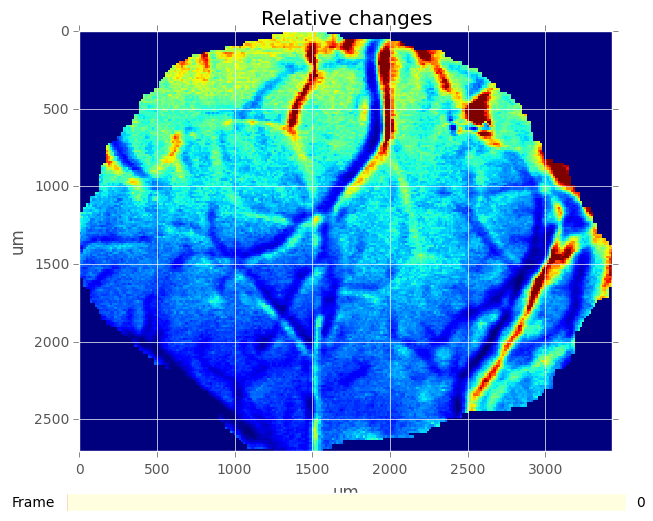

In [108]:
p2.fig.axes[0].set_title('Relative changes')
savefig(data_path + 'relative_changes_figure.pdf') #alternatively .png .svg . eps
gcf()

Lets calculate size of the different areas in mm^2

In [109]:
# Calulating area of craniotomy in um^2
craniotomy_area = area_in_pixels([tranges_min[0]], dt, (0, 2000))

# Calulating craniotomy area in um^2
craniotomy_area_mm2 = pixels2mm2(craniotomy_area, pixel_size)

print 'size craniotomy area = ' + str(craniotomy_area_mm2) + ' mm^2'

#mask penumbra for each of the tranges
penumbra_areas = area_in_pixels(tranges_min, dt, penumbra)

# Calulating areas of penumbra in um^2
penumbra_areas_mm2 = pixels2mm2(penumbra_areas, pixel_size)

print 'size penumbra areas = ' + str(penumbra_areas_mm2) + ' mm^2'

#mask core for each of the tranges
core_areas = area_in_pixels(tranges_min, dt, core)

# Calulating areas of core in um^2
core_areas_mm2 = pixels2mm2(core_areas, pixel_size)

print 'size core areas = ' + str(core_areas_mm2) + ' mm^2'

#mask healthy for each of the tranges
healthy_areas = area_in_pixels(tranges_min, dt, healthy)

# Calulating areas of healthy in um^2
healthy_areas_mm2 = pixels2mm2(healthy_areas, pixel_size)

print 'size healthy areas = ' + str(healthy_areas_mm2) + ' mm^2'

size craniotomy area = [6.8695846721213769] mm^2
size penumbra areas = [0.0, 4.7410266368422338, 4.7051588938639011, 5.4648660601111887, 5.9992346377036396] mm^2
size core areas = [0.0, 0.36880956056816833, 0.94674630053542996, 0.79618283707271065, 0.56699403871963461] mm^2
size healthy areas = [6.8695846721213769, 1.7597484747109746, 1.2176794777220459, 0.60853577493747779, 0.30335599569810329] mm^2


In [110]:
#make dataframe with all area data
time_lab = []
for r in tranges_min:
    time_lab.append("%0.0f to %0.0f min"%tuple(r - occlusion_time))

print time_lab

area_data = pd.DataFrame({'whole cranie (mm^2)':craniotomy_area_mm2, 'healthy (mm^2)':healthy_areas_mm2, 
                                       'penumbra (mm^2)':penumbra_areas_mm2, 
                                       'core (mm^2)':core_areas_mm2},
                                         index = time_lab)

area_data

['-9 to -7 min', '3 to 5 min', '48 to 50 min', '77 to 79 min', '124 to 126 min']


core (mm^2)  healthy (mm^2)  penumbra (mm^2)  \
-9 to -7 min       0.000000        6.869585         0.000000   
3 to 5 min         0.368810        1.759748         4.741027   
48 to 50 min       0.946746        1.217679         4.705159   
77 to 79 min       0.796183        0.608536         5.464866   
124 to 126 min     0.566994        0.303356         5.999235   

                whole cranie (mm^2)  
-9 to -7 min               6.869585  
3 to 5 min                 6.869585  
48 to 50 min               6.869585  
77 to 79 min               6.869585  
124 to 126 min             6.869585

In [111]:
#normalise area results to whole cranie
area_data_norm = area_data / area_data.iloc[0]['whole cranie (mm^2)'] * 100

# renaming column names
area_data_norm.columns = ['core (%)', 'healthy (%)', 'penumbra (%)', 'whole cranie (%)']
area_data_norm

core (%)  healthy (%)  penumbra (%)  whole cranie (%)
-9 to -7 min     0.000000   100.000000      0.000000               100
3 to 5 min       5.368732    25.616519     69.014749               100
48 to 50 min    13.781711    17.725664     68.492625               100
77 to 79 min    11.589971     8.858407     79.551622               100
124 to 126 min   8.253687     4.415929     87.330383               100

In [112]:
#area_data_norm.rename(columns={'$a': 'a', '$b': 'b'}, inplace=True)
#area_data_norm

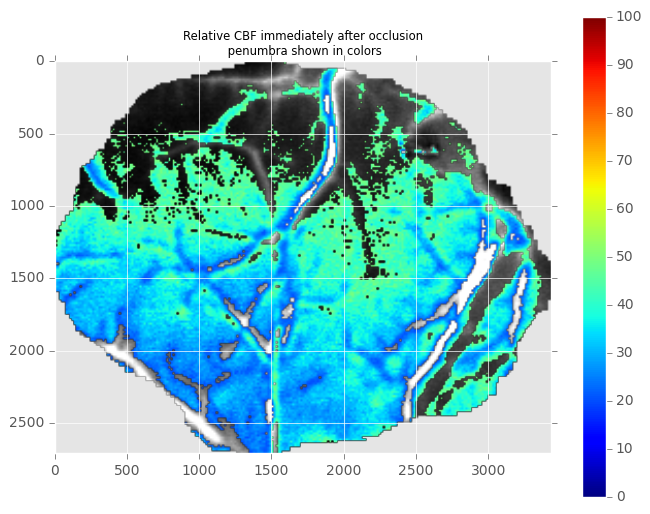

In [113]:
figure()

penumbra_area = (penumbra[0] < changes[1]) * (changes[1] < penumbra[1])

imshow(ma.masked_less_equal(base_frame, 0), cmap='gray',vmax=1000, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0])
imshow(ma.masked_where(-penumbra_area, changes[1]), vmin=0, vmax=100, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()
title('Relative CBF immediately after occlusion\n penumbra shown in colors',size='small')
savefig(data_path + 'relative_changes_masked_figure.pdf') #alternatively .png .svg . eps
gcf()

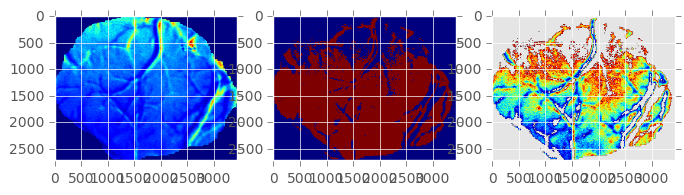

In [114]:
fs2.shape()
ma.masked_where(-penumbra_area, changes[1])

figure()
subplot(1,3,1)
imshow(changes[1], extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])

subplot(1,3,2)
imshow(penumbra_area, extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])

subplot(1,3,3)
imshow(ma.masked_where(-penumbra_area, changes[1]), extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])
gcf()

In [115]:
close ('all')

## Time-averaged maps

Again, I use list comprehensions. Now In also use a `map` function to apply my masking to each new array:

In [116]:
maps = map(fs2.fns[1], [fs2[x:y].mean(axis=0) for x,y in tranges_ind])
masks = [ma.masked_where((abs(m-100)<50)+(base_frame==0), m) for m in maps]

To show all maps together, we can define a convenience function, I'll call it `montage`:

**TODO** `montage` should be merged into `imfun.lib` in the future

Let's apply it and see what happens:

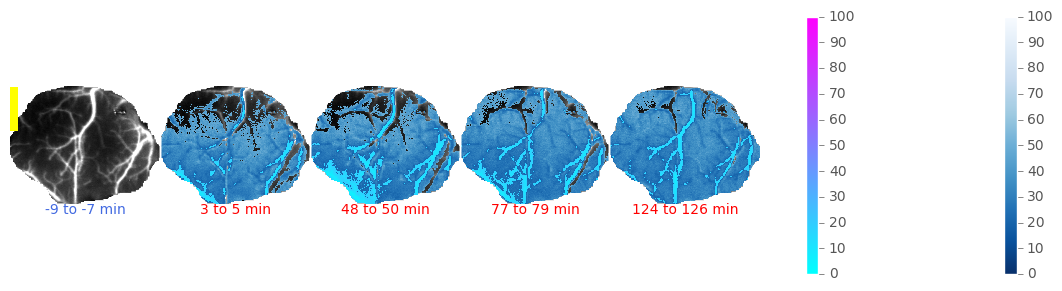

In [117]:
figure(figsize=(12,3))
neg_penumbra_areas_mask = [-x for x in penumbra_areas_mask]
neg_core_areas_mask = [-x for x in core_areas_mask]

bx = montage([base_frame]*len(maps),len(maps),mask=base_frame<=0,vmax=1000,cmap='gray')

x = montage(maps,len(maps),mask=(neg_penumbra_areas_mask)+(base_frame<=0),
            vmin = 0, vmax=100,interpolation='nearest', cmap = cm.Blues_r) #cm.Blues_r
colorbar()

cx = montage(maps,len(maps),mask=(neg_core_areas_mask)+(base_frame<=0),vmin = 0, vmax=100,interpolation='nearest', 
             cmap = 'cool')
colorbar()


h,w = maps[0].shape

for k,r in enumerate(tranges_min):
    color = k and 'red' or 'royalblue'
    text((k+0.5)*w, h+15, "%0.0f to %0.0f min"%tuple(r - occlusion_time), 
         color=color, horizontalalignment='center')

savefig(data_path + 'Time-averaged maps_figure.pdf') #alternatively .png .svg . eps    
gcf()

And as filled contours at user-specified levels:

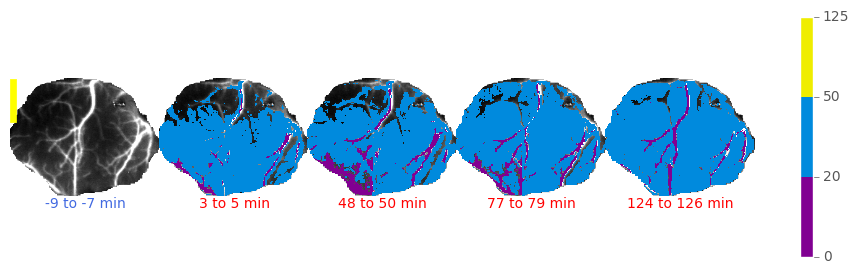

In [118]:

levels = [core[0], penumbra[0], penumbra[1], 125] # This value might be somewhat crazy
#extent = [0, (pixel_size * fs2.shape()[1]),(pixel_size * fs2.shape()[0]), 0]

f=figure(figsize=(12,3));
imshow(bx, cmap='gray', vmax=1000)

contourf(x, levels=levels, cmap='spectral'); #colorbar()
#x = montage(maps,len(maps),mask=(-penumbra_area)+(base_frame<=0),vmin = 0, vmax=150,interpolation='nearest'); colorbar()

contourf(cx, levels=levels, cmap='spectral'); colorbar()

setp(gca(), aspect='equal', xticks=[], yticks=[], frame_on=False)

h,w = maps[0].shape

for k,r in enumerate(tranges_min):
    color = k and 'red' or 'royalblue'
    text((k+0.5)*w, h+20, "%0.0f to %0.0f min"%tuple(r - occlusion_time), 
         color=color, horizontalalignment='center')

r = Rectangle((0,0), 10, 1e3/pixel_size, color='yellow')
gca().add_patch(r)

savefig(data_path + 'Time-averaged maps_sharp_figure.pdf') #alternatively .png .svg . eps
gcf()

** Exercises: **
  2. Export relative changes as a movie
  3. How woudl you overlay the now-cropped mask on top of the full frame from the frame sequence we started with?

In [119]:
close('all')

# Step 3. Evoked CBF

## Evoked CBF responses

<font color='red'>Set values for the program; stim_freqs, nr, epoch_starts

In [120]:
#description from log file
"""
Made craniotomy(bloody), placed LFP good responses. (slidely more medial)
Swicht alfa
Took a good blood gas. 

LSI
Strange activity involving full hemisphere
First stim at 24.50 in LSI file a (spike file a at 35:55)
LSI gave Good responses

started LSI file b in spike file a at 01:06:24 
Made MCAO el at 6.30 and occluded at 07.50 in LSI file b followed by bleading and csf

Perfect occlusion, nealy no medial penumba
Decresed spontaneous activity in penumbra

PID at ca 13.50 in medial rois in LSI file b 

Stim at 23.00 in LSI file b( (lateral rois Attenuated) CBF responses) BP response

started LSI file c in spike file a at 2:02:20 


LSI file d start at 2:46:22

Stim at 01.16 in LSI file d((very Attenuated CBF responses)

"""


'\nMade craniotomy(bloody), placed LFP good responses. (slidely more medial)\nSwicht alfa\nTook a good blood gas. \n\nLSI\nStrange activity involving full hemisphere\nFirst stim at 24.50 in LSI file a (spike file a at 35:55)\nLSI gave Good responses\n\nstarted LSI file b in spike file a at 01:06:24 \nMade MCAO el at 6.30 and occluded at 07.50 in LSI file b followed by bleading and csf\n\nPerfect occlusion, nealy no medial penumba\nDecresed spontaneous activity in penumbra\n\nPID at ca 13.50 in medial rois in LSI file b \n\nStim at 23.00 in LSI file b( (lateral rois Attenuated) CBF responses) BP response\n\nstarted LSI file c in spike file a at 2:02:20 \n\n\nLSI file d start at 2:46:22\n\nStim at 01.16 in LSI file d((very Attenuated CBF responses)\n\n'

spike file
<img src="spike overview 091.tiff">

In [137]:
stim_freqs = [1, 2, 3, 5, 10] # Hz

nf = len(stim_freqs) # number of different stimulation frequencies( Hz)

nr = 3 # number of times the train is repeated
#nt = 3 # number of different timepoints we have recorded stimulations

epoch_starts = [minute2ind(minsec2mindec(24.50), dt), 
                int(fsborders[0]) + minute2ind(minsec2mindec(23.00), dt), 
                int(fsborders[2]) + minute2ind(minsec2mindec(1.16), dt)]
#, 
                #int(fsborders[2]) + minute2ind(minsec2mindec(35.035), dt)] # first stimulation of each time point, can also be made in to a list
#epoch_starts = [0.45*1500, 9.41*1500, 39.13*1500, 48.19*1500, 71.91*1500, 81.40*1500] # first stimulation of each time point, can also be made in to a list

baseline_horizon = minute2ind(minsec2mindec(0.30), dt) # in frame counts (=seconds if Moor run in hi-res mode)
fnmap_horizon = minute2ind(minsec2mindec(0.30), dt) # in frame counts (=seconds if Moor run in hi-res mode)
afterstim_horizon = minute2ind(minsec2mindec(2.00), dt)
stim_sep = minute2ind(minsec2mindec(2.00), dt) # Interval between stimulations

print epoch_starts
epochs = [stim_freqs] + [[start + (nrep*nf*stim_sep)+stim_sep*arange(nf) for nrep in range(nr)] 
                         for start in epoch_starts]# array of stimulation onset times
epochs


[1490, 4690, 8998]


[[1, 2, 3, 5, 10],
 [array([1490, 1610, 1730, 1850, 1970]),
  array([2090, 2210, 2330, 2450, 2570]),
  array([2690, 2810, 2930, 3050, 3170])],
 [array([4690, 4810, 4930, 5050, 5170]),
  array([5290, 5410, 5530, 5650, 5770]),
  array([5890, 6010, 6130, 6250, 6370])],
 [array([8998, 9118, 9238, 9358, 9478]),
  array([ 9598,  9718,  9838,  9958, 10078]),
  array([10198, 10318, 10438, 10558, 10678])]]

### Making functional map

In [138]:
t0 = epochs[1][0][1] # put in frame number of first stimulation
fs2.fns=[lambda f: filt.gauss_smooth(f)] 
bf = fs2.mean_frame([t0-baseline_horizon, t0])
sf = fs2.mean_frame([t0, t0+fnmap_horizon])
fm = 100*((sf/bf)-1)

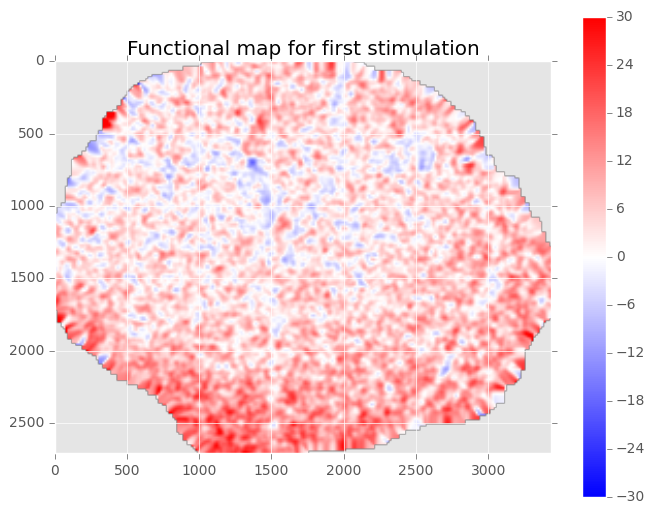

In [139]:
figure()
imshow(fm, vmax=30, vmin=-30, cmap=cm.bwr, extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0]); colorbar()
title('Functional map for first stimulation')
savefig(data_path + 'functional_map_figure.pdf')
gcf() 

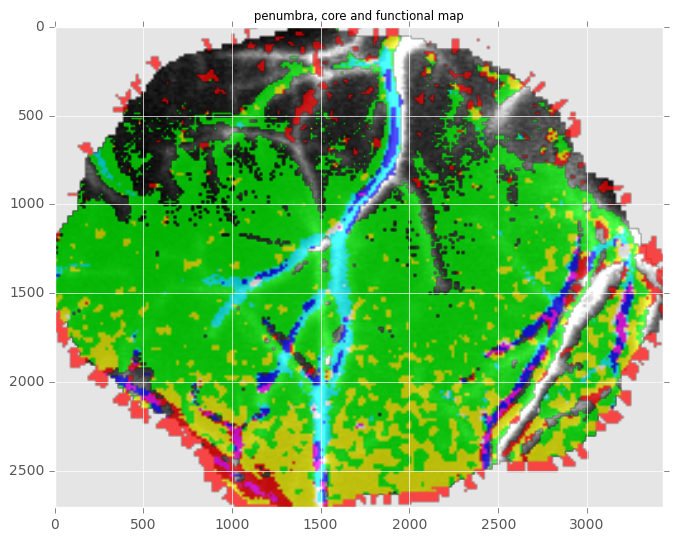

In [140]:
figure()
fm_cut = (10 < fm) * (fm < 30)

penumbra_area = (penumbra[0] < changes[1]) * (changes[1] < penumbra[1])

imshow(ma.masked_less_equal(base_frame, 0), cmap='gray',vmax=1000, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0])
#imshow(ma.masked_where(-penumbra_area, changes[1]), vmin=0, vmax=100, cmap = 'Greens', aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
#                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()
#imshow(ma.masked_where(-fm_cut, fm), vmin=0,alpha = 0.5, cmap = 'Reds', vmax=20, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
#                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()

z = zeros_like(fm_cut)

red_map = dstack([fm_cut, z, z, fm_cut])
green_map = dstack([z, penumbra_area, z, penumbra_area])
blue_map = dstack([z, z, core_areas[4], core_areas[4]])

imshow(clip(green_map + red_map + blue_map, 0, 1), aspect='equal',
       alpha = 0.7,
       extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])


title('penumbra, core and functional map',size='small')
savefig(data_path + 'penumbra, core and functional map_figure.pdf') #alternatively .png .svg . eps
gcf()

###### Making a frame sequense of the normalized evoked response

In [141]:
print data_path
name3 = !ls {data_path + '*.h5'} 
print name3
fs3 = fseq.open_seq(name3[0])
fs3.meta['axes'] = lib.alist_to_scale([(frame_rate, 's'), (pixel_size, 'um'), (pixel_size, 'um')])



/Users/cfw958/Desktop/lsi/091/
['/Users/cfw958/Desktop/lsi/091/091-cropped.h5']
The file /Users/cfw958/Desktop/lsi/091/091-cropped.h5 has the following data sets: [u'data']


In [142]:
arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence

In [143]:
base_frame = mean(arr[:30].astype(float), axis=0)
func_map = 100*(arr[30:]/base_frame - 1).mean(axis=0)

In [144]:
p3 = ui.Picker(fs3_cut)
p3.start(mean_frame = base_frame, vmax = 1000)

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x13dd62ad0>,
 <imfun.ui.Picker instance at 0x13bf41320>)

<font color='red'>Place rois in the functional area. two in penumbra and one in healthy tissue

In [145]:
if os.path.isfile(data_path+ '091-funcmap-rois.pickle'):
    p3.load_rois(data_path+ '091-funcmap-rois.pickle')
else:
    print 'place rois !!!'

<font color='red'>If you want to save another version of rois change data file name or reposition in picker

Saved ROIs to  /Users/cfw958/Desktop/lsi/091/091-funcmap-rois.pickle


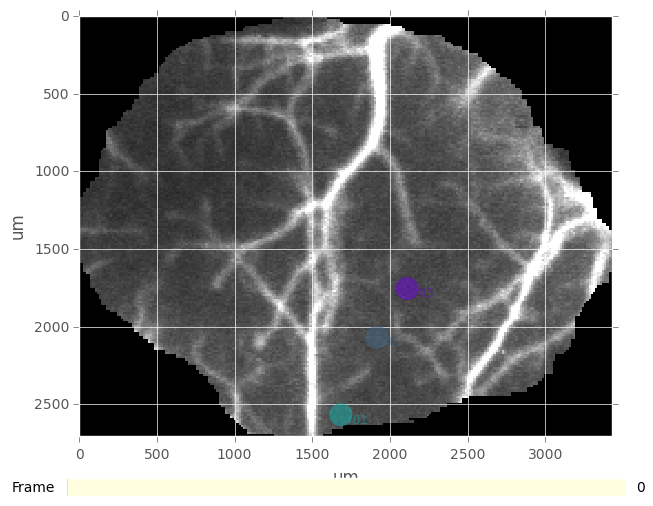

In [146]:
rois = p3.export_rois(data_path + '091-funcmap-rois.pickle') #
roi_file = '091-funcmap-rois.pickle'
savefig(data_path + 'roi_placement_figure.pdf')
gcf()

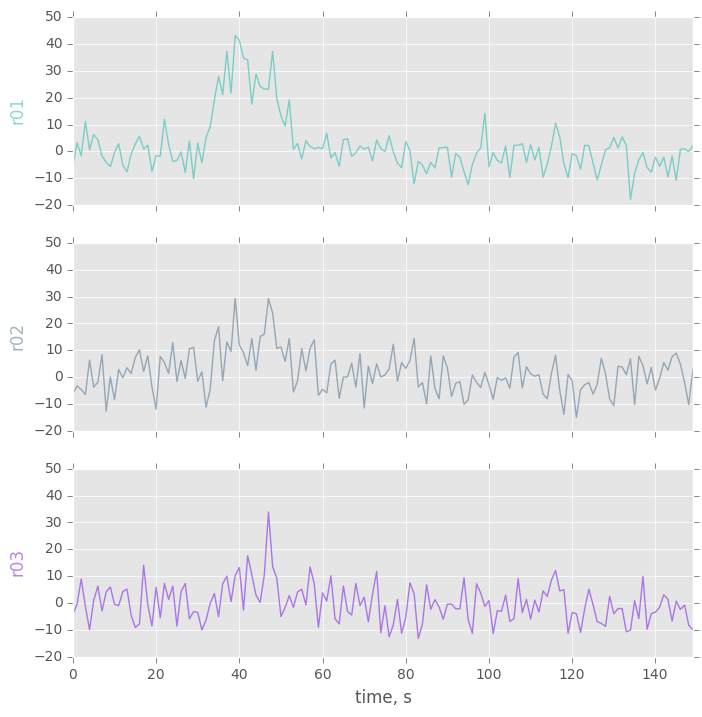

In [147]:
p3.show_zview(normp = lambda v: 100*(v/mean(1.0*v[:sec2ind(20, dt)]) -1)) # Show normalized time series from ROIs
f = gcf()
f.set_size_inches((8,8))
savefig(data_path + 'roi_single_stim_figure.pdf')
f

In [148]:
#resting CBF in ROIS
#take average of trange for each ROI and normalize to trange_min[0]

p4 = ui.Picker(fs3, verbose=False)
p4.start(mean_frame = base_frame, vmax = 1000)
p4.load_rois(data_path + roi_file)    

connecting callbacks to picker


In [149]:
data = p4.get_timeseries()

resting_cbf = pd.DataFrame()
for roi in range(len(rois)):
    time_series = pd.Series()
    mean_resting = []
    for trange in range(len(tranges_ind)):
        resting = (data[roi][tranges_ind[trange][0] : tranges_ind[trange][1]])
        mean_resting.append(resting.mean())
        norm_resting = 100 * mean_resting[trange] / mean_resting[0] 
        x = pd.Series(norm_resting, index = [time_lab[trange]]) 
        x.name = p3.roi_tags()[roi]
        time_series = time_series.append(x)
    resting_cbf = resting_cbf.append(time_series)
    print 'time series in correct order: ', time_series
    print 'order messed up when added to dataframe:', resting_cbf
resting_cbf.to_csv(data_path+'resting CBF norm.csv')

resting_cbf

time series in correct order:  -9 to -7 min      100.000000
3 to 5 min         33.267063
48 to 50 min       25.363400
77 to 79 min       29.366983
124 to 126 min     33.250886
Name: r01, dtype: float64
order messed up when added to dataframe:      -9 to -7 min  124 to 126 min  3 to 5 min  48 to 50 min  77 to 79 min
r01           100       33.250886   33.267063       25.3634     29.366983
time series in correct order:  -9 to -7 min      100.000000
3 to 5 min         32.849584
48 to 50 min       27.541369
77 to 79 min       28.300265
124 to 126 min     32.164086
Name: r03, dtype: float64
order messed up when added to dataframe:      -9 to -7 min  124 to 126 min  3 to 5 min  48 to 50 min  77 to 79 min
r01           100       33.250886   33.267063     25.363400     29.366983
r03           100       32.164086   32.849584     27.541369     28.300265
time series in correct order:  -9 to -7 min      100.000000
3 to 5 min         38.054989
48 to 50 min       33.504727
77 to 79 min       33.3565

-9 to -7 min  124 to 126 min  3 to 5 min  48 to 50 min  77 to 79 min
r01           100       33.250886   33.267063     25.363400     29.366983
r03           100       32.164086   32.849584     27.541369     28.300265
r02           100       35.193143   38.054989     33.504727     33.356545

In [150]:
resting_cbf

-9 to -7 min  124 to 126 min  3 to 5 min  48 to 50 min  77 to 79 min
r01           100       33.250886   33.267063     25.363400     29.366983
r03           100       32.164086   32.849584     27.541369     28.300265
r02           100       35.193143   38.054989     33.504727     33.356545

## Extracting data from many stimulations

In [151]:
def extract_roi_data():
    agg = []
    stim_freqs = epochs[0]
    print stim_freqs
    tvec = arange(-baseline_horizon, afterstim_horizon)
    for epnum,epoch in enumerate(epochs[1:]):
        for repnum, rep in enumerate(epoch):
            for t0,freq in zip(rep, stim_freqs):
                print t0,freq
                arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
                fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence
                p3 = ui.Picker(fs3_cut, verbose=False)
                p3.start()
                p3.load_rois(data_path + roi_file)
                data = 100*array(p3.get_timeseries(normp=baseline_horizon))
                headers = [' : '.join(('epo%d'%(epnum+1), 'rep%d'%(repnum+1) ,'%dHz'%freq, tag)) for tag in p3.roi_tags()]
                x = pd.DataFrame({name:v for name,v in zip(headers, data)}, index=tvec)
                agg.append(x)
                close()
    return agg

In [152]:
table = extract_roi_data()

[1, 2, 3, 5, 10]
1490 1
connecting callbacks to picker
1610 2
connecting callbacks to picker
1730 3
connecting callbacks to picker
1850 5
connecting callbacks to picker
1970 10
connecting callbacks to picker
2090 1
connecting callbacks to picker
2210 2
connecting callbacks to picker
2330 3
connecting callbacks to picker
2450 5
connecting callbacks to picker
2570 10
connecting callbacks to picker
2690 1
connecting callbacks to picker
2810 2
connecting callbacks to picker
2930 3
connecting callbacks to picker
3050 5
connecting callbacks to picker
3170 10
connecting callbacks to picker
4690 1
connecting callbacks to picker
4810 2
connecting callbacks to picker
4930 3
connecting callbacks to picker
5050 5
connecting callbacks to picker
5170 10
connecting callbacks to picker
5290 1
connecting callbacks to picker
5410 2
connecting callbacks to picker
5530 3
connecting callbacks to picker
5650 5
connecting callbacks to picker
5770 10
connecting callbacks to picker
5890 1
connecting callbacks 

In [153]:
x = pd.concat(table, axis=1) # stack columns
x.to_csv(data_path+'raw stimulations.csv')

In [154]:
x.keys()

Index([ u'epo1 : rep1 : 1Hz : r01',  u'epo1 : rep1 : 1Hz : r02',
        u'epo1 : rep1 : 1Hz : r03',  u'epo1 : rep1 : 2Hz : r01',
        u'epo1 : rep1 : 2Hz : r02',  u'epo1 : rep1 : 2Hz : r03',
        u'epo1 : rep1 : 3Hz : r01',  u'epo1 : rep1 : 3Hz : r02',
        u'epo1 : rep1 : 3Hz : r03',  u'epo1 : rep1 : 5Hz : r01', 
       ...
        u'epo3 : rep3 : 2Hz : r03',  u'epo3 : rep3 : 3Hz : r01',
        u'epo3 : rep3 : 3Hz : r02',  u'epo3 : rep3 : 3Hz : r03',
        u'epo3 : rep3 : 5Hz : r01',  u'epo3 : rep3 : 5Hz : r02',
        u'epo3 : rep3 : 5Hz : r03', u'epo3 : rep3 : 10Hz : r01',
       u'epo3 : rep3 : 10Hz : r02', u'epo3 : rep3 : 10Hz : r03'],
      dtype='object', length=135)

In [155]:
x.describe()

epo1 : rep1 : 1Hz : r01  epo1 : rep1 : 1Hz : r02  \
count               150.000000               150.000000   
mean                  4.027359                 3.038001   
std                   7.138265                 6.738859   
min                 -12.104684               -12.114859   
25%                  -1.288762                -1.857228   
50%                   4.068617                 2.479321   
75%                   8.582582                 8.389492   
max                  26.162305                18.833823   

       epo1 : rep1 : 1Hz : r03  epo1 : rep1 : 2Hz : r01  \
count               150.000000               150.000000   
mean                 -0.804866                 2.703000   
std                   6.573814                10.868095   
min                 -17.251173               -17.690604   
25%                  -4.771661                -3.783406   
50%                  -1.560645                 1.026327   
75%                   3.255878                 4.174004   
max                  23.375064                43.621753   

       epo1 : rep1 : 2Hz : r02  epo1 : rep1 : 2Hz : r03  \
count               150.000000               150.000000   
mean                 -0.354960                 0.448307   
std                   7.194510                 7.837815   
min                 -13.385679               -16.112154   
25%                  -5.671209                -5.001138   
50%                  -0.990401                -0.250014   
75%                   4.154144                 5.561092   
max                  33.443534                27.520008   

       epo1 : rep1 : 3Hz : r01  epo1 : rep1 : 3Hz : r02  \
count               150.000000               150.000000   
mean                  3.268654                 1.226651   
std                  10.961652                 7.415469   
min                 -15.723131               -13.236556   
25%                  -3.891872                -4.235561   
50%                   0.937692                 0.768241   
75%                   7.779042                 5.297986   
max                  40.794965                34.603011   

       epo1 : rep1 : 3Hz : r03  epo1 : rep1 : 5Hz : r01  \
count               150.000000               150.000000   
mean                  1.713817                 3.175798   
std                   7.548412                 9.733305   
min                 -14.648609               -17.366119   
25%                  -4.173089                -3.384472   
50%                   1.610464                 1.818051   
75%                   6.512225                 8.574450   
max                  22.349523                34.190265   

                 ...             epo3 : rep3 : 2Hz : r03  \
count            ...                          150.000000   
mean             ...                           -1.285447   
std              ...                            9.753359   
min              ...                          -23.461026   
25%              ...                           -7.969706   
50%              ...                           -2.033906   
75%              ...                            4.003476   
max              ...                           26.111199   

       epo3 : rep3 : 3Hz : r01  epo3 : rep3 : 3Hz : r02  \
count               150.000000               150.000000   
mean                 -2.881525                 2.468602   
std                   9.208779                10.257304   
min                 -22.581505               -22.145771   
25%                  -9.293953                -4.932377   
50%                  -3.926928                 1.846506   
75%                   3.500233                 8.983854   
max                  25.635042                31.943327   

       epo3 : rep3 : 3Hz : r03  epo3 : rep3 : 5Hz : r01  \
count               150.000000               150.000000   
mean                 -0.759291                 3.273365   
std                   9.605617                 7.868039   
min                 -18.076536        

As an example, let's plot all time points for a specific frequency and roi number. We will generalize and make it a function later.

In [156]:
print 'valid rois:', unique([c.split(':')[-1].strip() for c in x.columns])
print 'valid epo:', unique([c.split(':')[0].strip() for c in x.columns])
print 'valid freq:', sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0]))

valid rois: [u'r01' u'r02' u'r03']
valid epo: [u'epo1' u'epo2' u'epo3']
valid freq: [u'1Hz', u'2Hz', u'3Hz', u'5Hz', u'10Hz']


<font color='red'>Set stimulation of interest

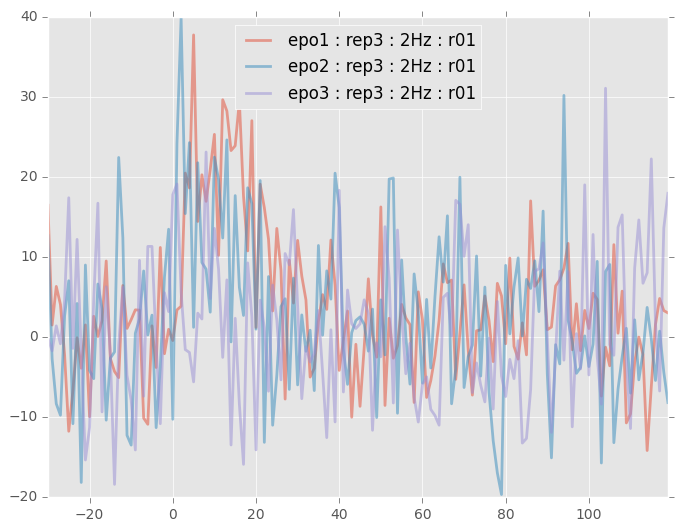

In [160]:

roi = ['r01']
freq = ['2Hz']
epo = ['epo1', 'epo2', 'epo3', 'epo4']
rep = ['rep3']

#cols = [c for c in x.columns if satisfies_keys(c, [roi, freq, epo, rep])]
cols = smart_filter_columns(x, [roi, freq, epo, rep])

#show raw
x[cols].plot(lw=2, alpha=0.5)
gcf()

Lets apply a running average to all the stimulations

In [161]:
xsmooth = pd.rolling_mean(x, 3, min_periods=None, freq=None, center=False, how=None)

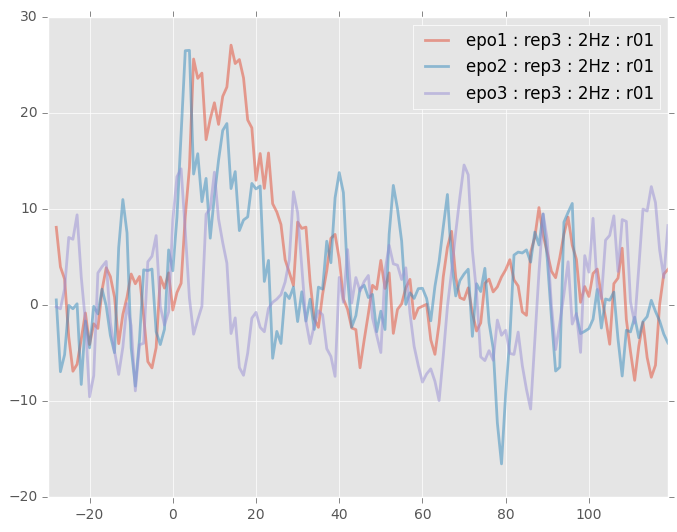

In [162]:
#show smooth
xsmooth[cols].plot(lw=2, alpha=0.5, legend=True)
savefig(data_path + 'timepoints_stimulations_figure.pdf')
gcf()

In [163]:
print xsmooth.size
close('all')

20250


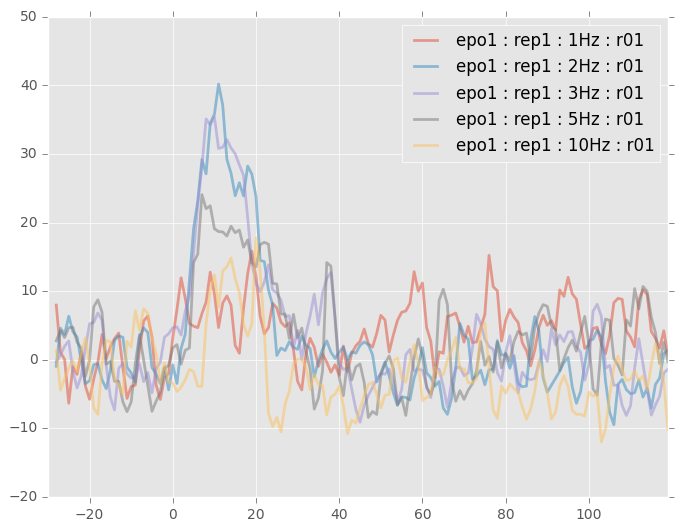

In [164]:
all_freqs_before = smart_filter_columns(xsmooth, [['r01'], ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz'], ['rep1'], ['epo1']])
xsmooth[all_freqs_before].plot(lw=2, alpha=0.5, legend=True)
savefig(data_path + 'frequencies_stimulations_figure.pdf')
gcf()

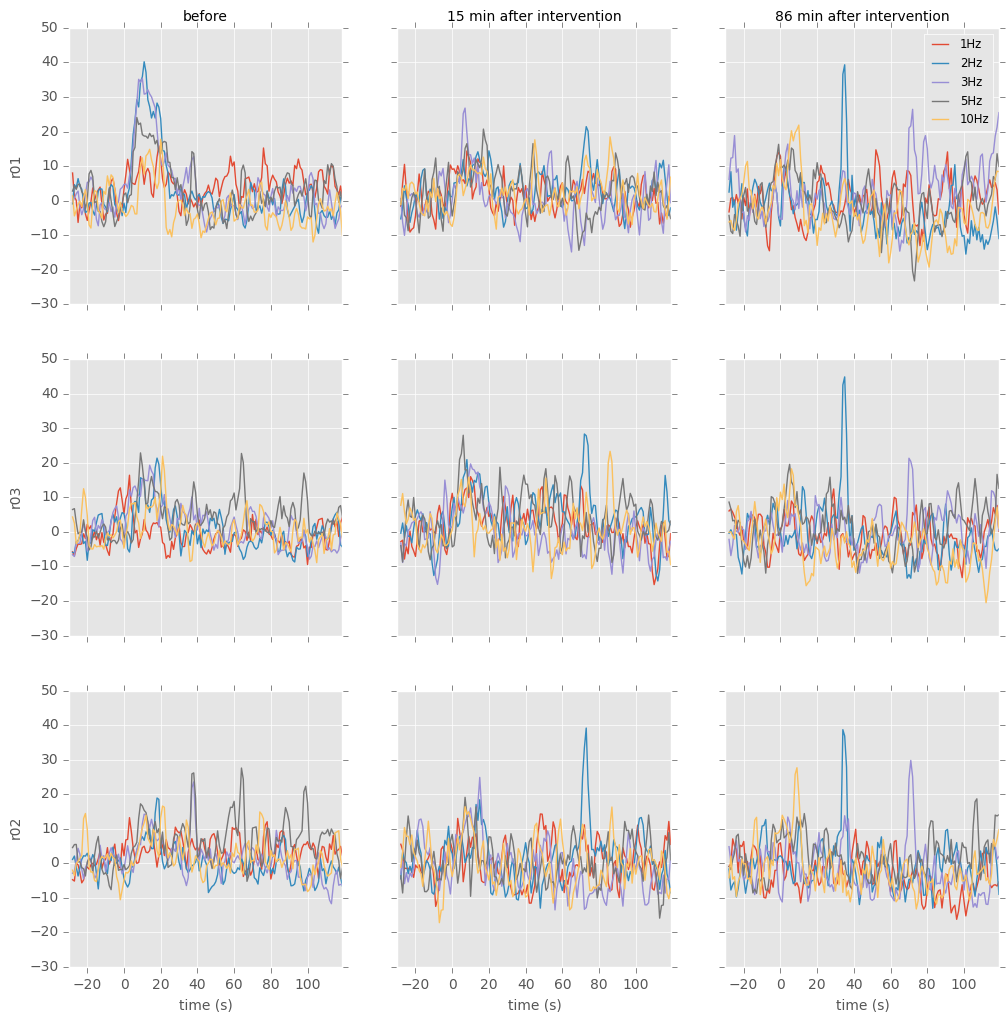

In [165]:
#show rep 1
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth, [roi, 'epo%d'%(col+1), 'rep1'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep1.pdf')
gcf()

In [187]:
xsmooth_exclude = xsmooth.copy(deep=True)

In [188]:
#exclude specific traces
#del xsmooth_exclude['epo3 : rep1 : 2Hz : r01']
#del xsmooth_exclude['epo3 : rep1 : 2Hz : r03']
#del xsmooth_exclude['epo3 : rep1 : 2Hz : r02']

In [189]:
print xsmooth.size
print xsmooth_exclude.size

20250
20250


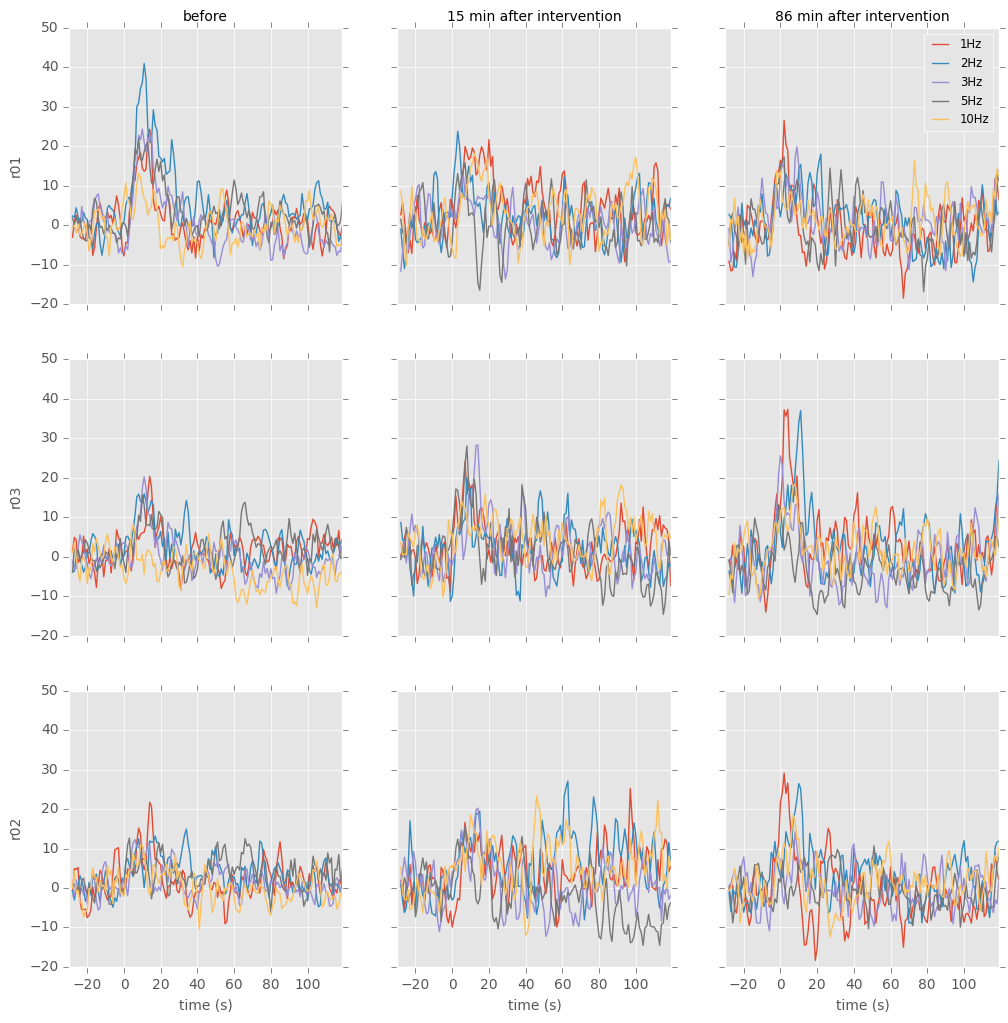

In [190]:
#show rep 2
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth, [roi, 'epo%d'%(col+1), 'rep2'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep2.pdf')
gcf()

In [191]:
#exclude specific traces
#del xsmooth_exclude['epo3 : rep2 : 2Hz : r01']
#del xsmooth_exclude['epo3 : rep2 : 2Hz : r04']

print xsmooth.size
print xsmooth_exclude.size

20250
20250


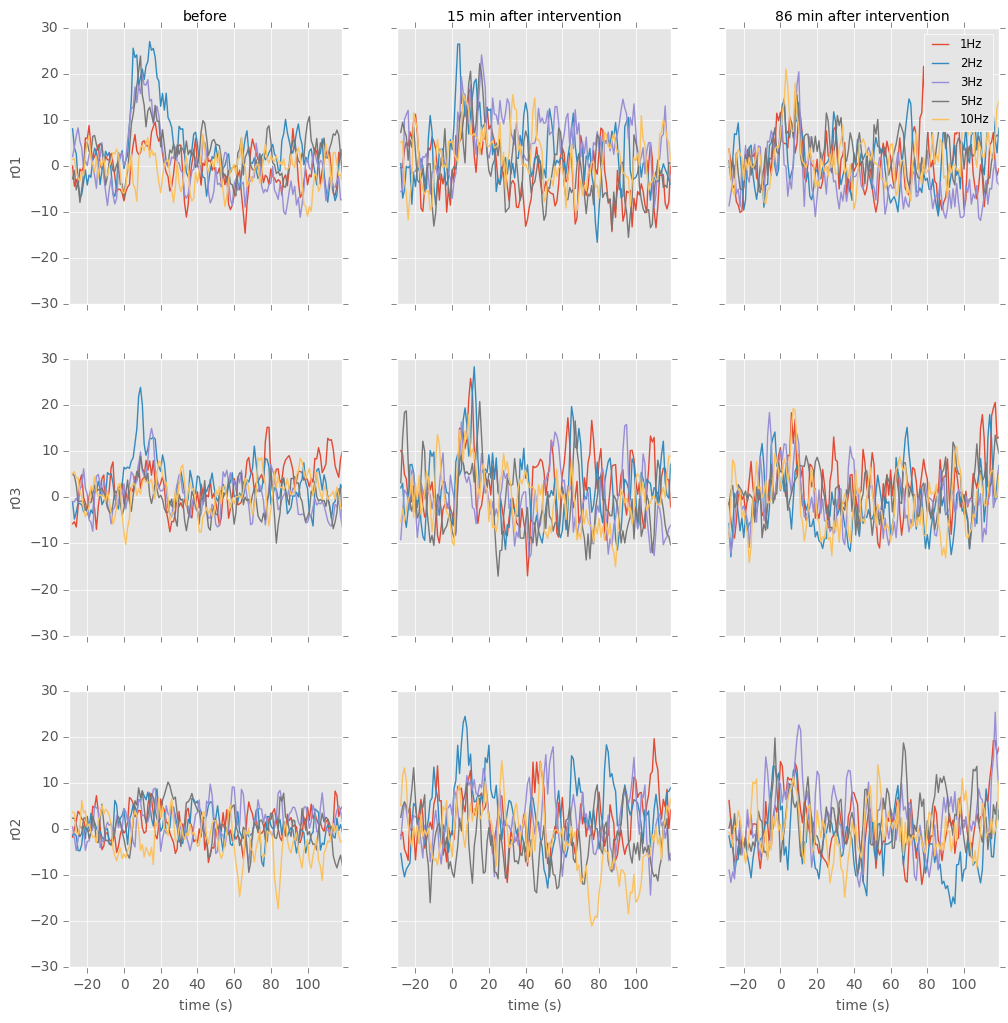

In [192]:
#show rep 3
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth, [roi, 'epo%d'%(col+1), 'rep3'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep3.pdf')
gcf()

In [193]:
#exclude specific traces
#del xsmooth_exclude['epo3 : rep3 : 2Hz : r01']
#del xsmooth_exclude['epo3 : rep3 : 2Hz : r04']

print xsmooth.size
print xsmooth_exclude.size

20250
20250


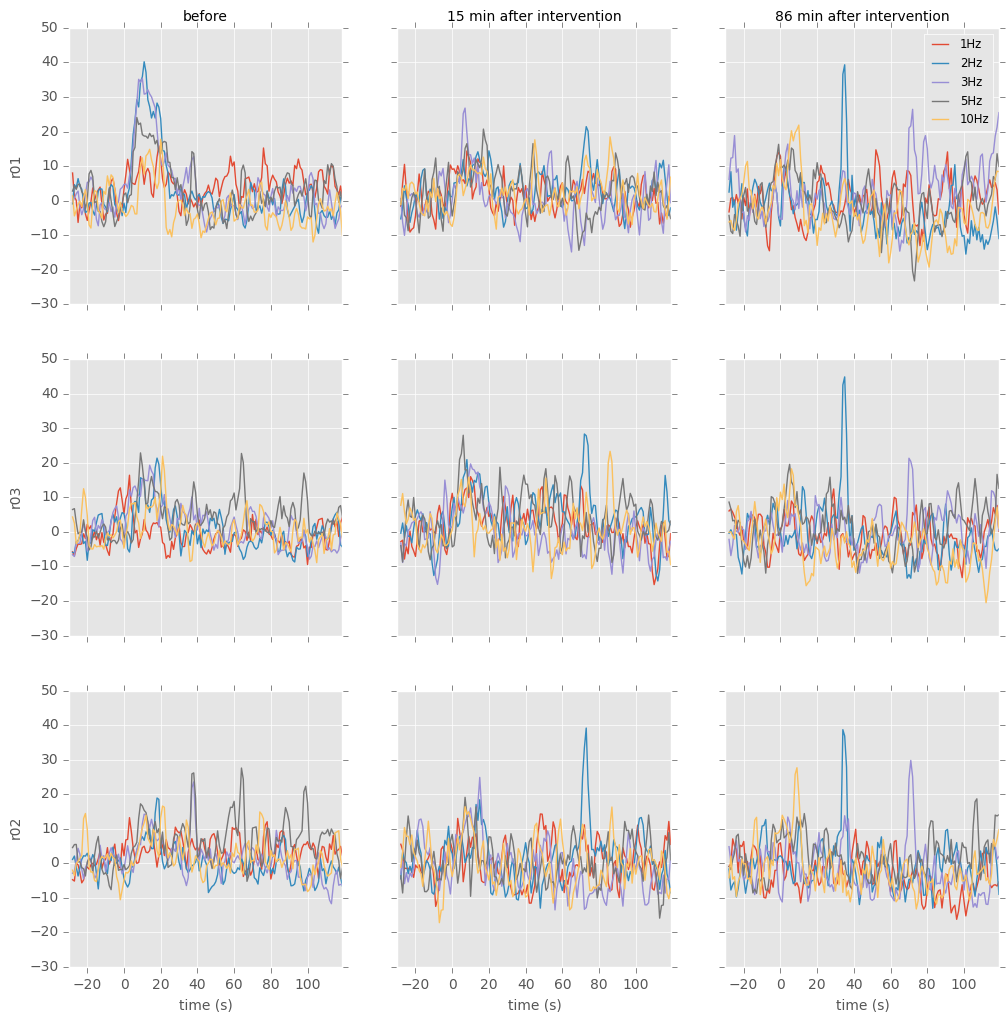

In [194]:
#show rep 1 with exclusion
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth_exclude, [roi, 'epo%d'%(col+1), 'rep1'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep1_with_exclusion.pdf')
gcf()

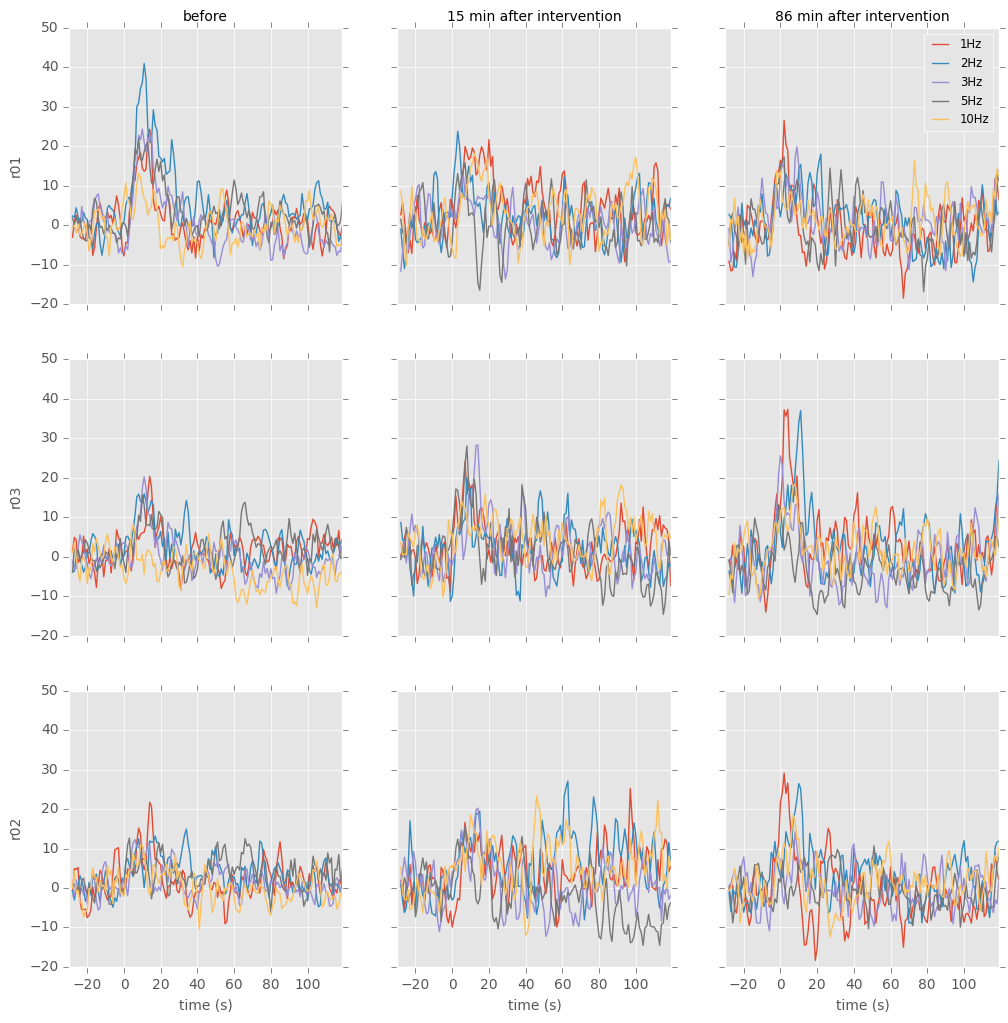

In [195]:
#show rep 2 with exclusion
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth_exclude, [roi, 'epo%d'%(col+1), 'rep2'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)

savefig(data_path + 'all_stimulations_figure_rep2_with_exclusion.pdf')
gcf()

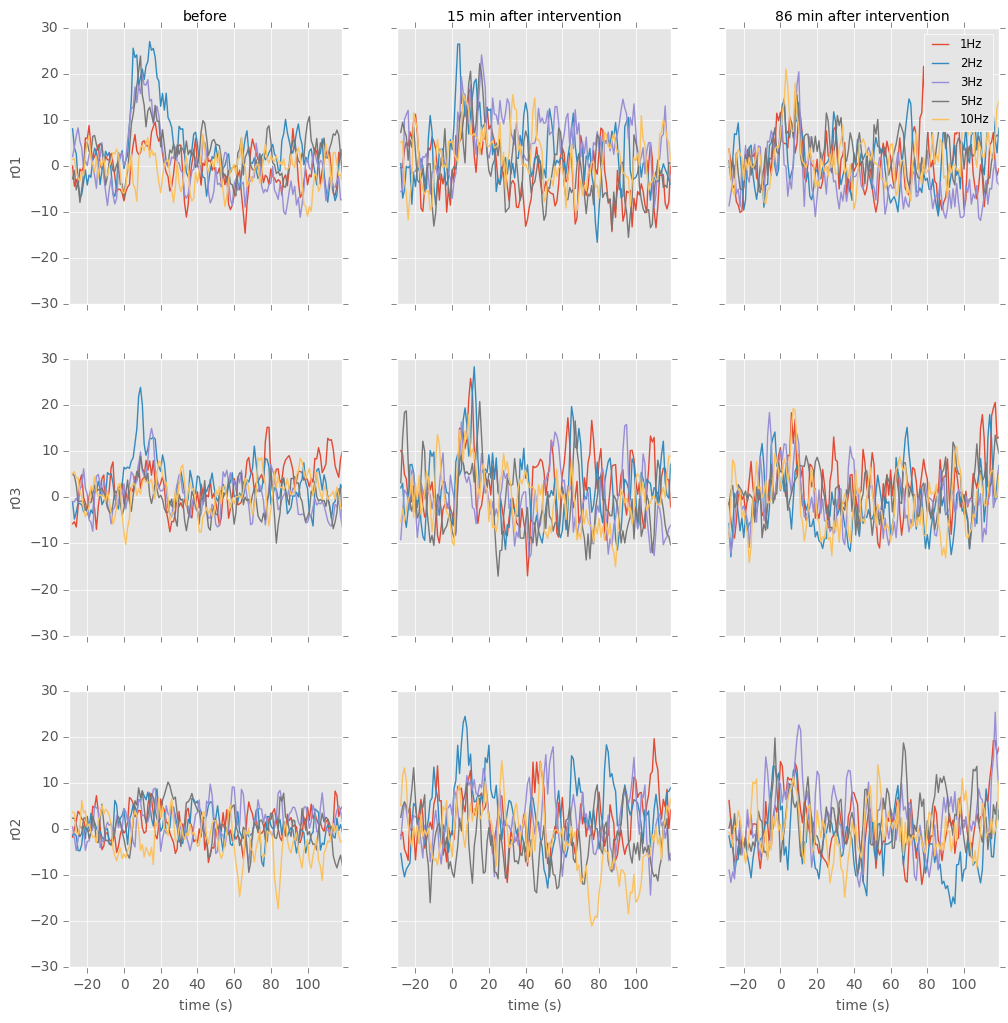

In [196]:
#show rep 3 with exclusion
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth_exclude, [roi, 'epo%d'%(col+1), 'rep3'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep3_with_exclusion.pdf')
gcf()

In [197]:
def get_average_of_trace(dataframe):
    """find repeated stimulations in a pd.dataframe and return a dataframe 
    contaning the average,sd and sem of theese stimulations """
    roi_all = unique([c.split(':')[-1].strip() for c in x.columns])#['r01', 'r02', 'r03']
    print roi_all
    freq_all = sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0])) #['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
    print freq_all
    epo_all = unique([c.split(':')[0].strip() for c in x.columns]) #['epo1', 'epo2', 'epo3', 'epo4']
    print epo_all
    average_results = pd.DataFrame()    
    for roi in roi_all:
        for freq in freq_all:
            for epo in epo_all:
                test_rep = smart_filter_columns(dataframe, [roi, freq, epo])
                rep_n = len(test_rep)
                average = dataframe[test_rep].mean(axis=1, skipna=None, level=None, numeric_only=None)
                sd = dataframe[test_rep].mean(axis=1, skipna=None, level=None, numeric_only=None)
                average_results[' : '.join((epo, freq, roi, 'rep_n=%d'%rep_n))] = average
    return average_results

In [198]:
test = get_average_of_trace(xsmooth_exclude)

[u'r01' u'r02' u'r03']
[u'1Hz', u'2Hz', u'3Hz', u'5Hz', u'10Hz']
[u'epo1' u'epo2' u'epo3']


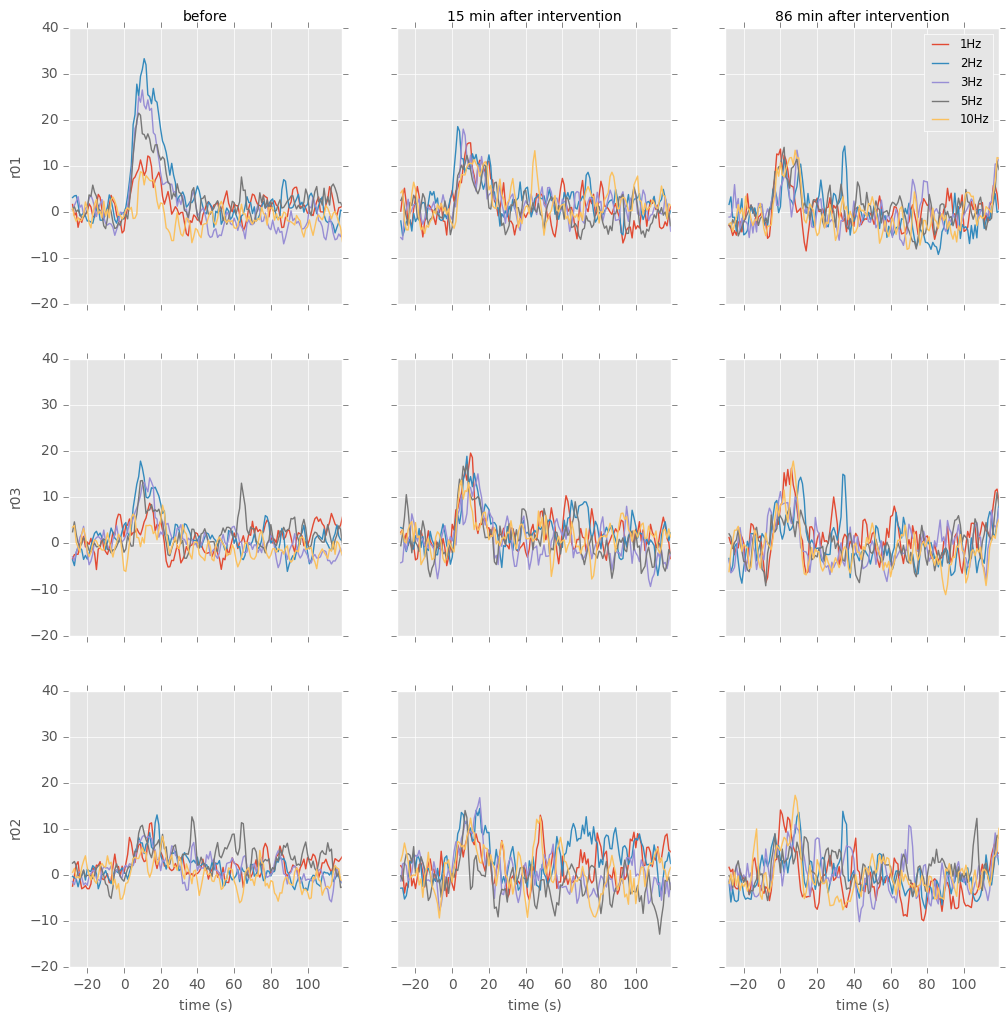

In [199]:
#show average traces of reps, add SEM or SD
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(test, [roi, 'epo%d'%(col+1)])
        subtable = test[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_avr_reps.pdf')
gcf()

In [200]:
#set time of interest
toi = xsmooth_exclude.iloc[30:50] 

# calculates parameters
peak = toi.max(axis=None, skipna=None, level=None, numeric_only=None) #(% of baseline)
mean = toi.mean(axis=None, skipna=None, level=None, numeric_only=None) #(AU)
ttp = ind2sec(toi.idxmax(axis=0, skipna=True), dt) # (s)  

results = pd.DataFrame({'peak (%)':peak, 'mean (%)':mean, 'ttp (s)':ttp})
results

mean (%)   peak (%)  ttp (s)
epo1 : rep1 : 1Hz : r01    7.647753  15.833150       19
epo1 : rep1 : 1Hz : r02    4.246594  13.247349        3
epo1 : rep1 : 1Hz : r03    2.981970  16.437292        3
epo1 : rep1 : 2Hz : r01   22.213375  40.198806       11
epo1 : rep1 : 2Hz : r02    4.743892  18.942069       18
epo1 : rep1 : 2Hz : r03    8.575150  21.394236       18
epo1 : rep1 : 3Hz : r01   22.277571  35.417379       10
epo1 : rep1 : 3Hz : r02    6.253818  14.264452       11
epo1 : rep1 : 3Hz : r03   10.893579  19.332271       14
epo1 : rep1 : 5Hz : r01   14.198796  24.076278        7
epo1 : rep1 : 5Hz : r02    7.889664  17.250699        9
epo1 : rep1 : 5Hz : r03    8.435291  22.906636        9
epo1 : rep1 : 10Hz : r01   4.320521  14.846020       14
epo1 : rep1 : 10Hz : r02   4.074018  13.999046       12
epo1 : rep1 : 10Hz : r03   4.557962  10.075420       17
epo1 : rep2 : 1Hz : r01    9.893551  24.306571       14
epo1 : rep2 : 1Hz : r02    8.601024  21.727958       14
epo1 : rep2 : 1Hz : r03    5.872950  20.374595       14
epo1 : rep2 : 2Hz : r01   21.327321  40.990019       11
epo1 : rep2 : 2Hz : r02    7.701561  13.187764       17
epo1 : rep2 : 2Hz : r03    9.478662  15.927299       11
epo1 : rep2 : 3Hz : r01   12.014412  24.375850       10
epo1 : rep2 : 3Hz : r02    6.036008  12.281318        6
epo1 : rep2 : 3Hz : r03    6.714841  20.194425       11
epo1 : rep2 : 5Hz : r01   12.666531  21.925237        8
epo1 : rep2 : 5Hz : r02    5.365565  12.686545        3
epo1 : rep2 : 5Hz : r03    6.478225  15.565687       10
epo1 : rep2 : 10Hz : r01   6.384773  13.084445        8
epo1 : rep2 : 10Hz : r02   4.463958  10.846661        9
epo1 : rep2 : 10Hz : r03  -0.894937   8.161633        5
...                             ...        ...      ...
epo3 : rep2 : 1Hz : r01    5.832595  26.554559        2
epo3 : rep2 : 1Hz : r02    4.740921  29.137073        2
epo3 : rep2 : 1Hz : r03   12.119446  37.316882        4
epo3 : rep2 : 2Hz : r01    8.537490  15.389583       11
epo3 : rep2 : 2Hz : r02   11.451340  26.476977       10
epo3 : rep2 : 2Hz : r03   15.572746  36.989178       11
epo3 : rep2 : 3Hz : r01    7.340660  19.907886        9
epo3 : rep2 : 3Hz : r02    4.348476  14.320958        8
epo3 : rep2 : 3Hz : r03    6.846718  25.552461        0
epo3 : rep2 : 5Hz : r01    3.551869  17.287681        2
epo3 : rep2 : 5Hz : r02    1.730790   7.786653       13
epo3 : rep2 : 5Hz : r03   -0.228091  12.059364        0
epo3 : rep2 : 10Hz : r01   4.472305  13.635390        0
epo3 : rep2 : 10Hz : r02   6.413354  18.534421        7
epo3 : rep2 : 10Hz : r03   7.518130  18.473462        8
epo3 : rep3 : 1Hz : r01    4.640090  12.507139       10
epo3 : rep3 : 1Hz : r02    6.716467  14.620854        0
epo3 : rep3 : 1Hz : r03    5.706942  18.411766        6
epo3 : rep3 : 2Hz : r01    3.425833  14.171238        2
epo3 : rep3 : 2Hz : r02    0.518719  13.210987        8
epo3 : rep3 : 2Hz : r03   -0.285785   8.390709       10
epo3 : rep3 : 3Hz : r01    1.755895  20.474698       10
epo3 : rep3 : 3Hz : r02    8.586349  22.606688       10
epo3 : rep3 : 3Hz : r03    4.257021  13.762199        9
epo3 : rep3 : 5Hz : r01    7.437327  15.416225        9
epo3 : rep3 : 5Hz : r02    2.415931  11.301021       15
epo3 : rep3 : 5Hz : r03    4.409093   9.055711       14
epo3 : rep3 : 10Hz : r01   7.031072  21.053339        3
epo3 : rep3 : 10Hz : r02   2.061442  11.312565        7
epo3 : rep3 : 10Hz : r03   4.328761  19.360300        7

[135 rows x 3 columns]

In [201]:
average_of_rep_results = pd.DataFrame({'peak avr (%)':get_average_of_rep(peak), 
                                       'mean avr (%)':get_average_of_rep(mean), 
                                       'ttp avr (s)':get_average_of_rep(ttp)})
average_of_rep_results

mean avr (%)  peak avr (%)  ttp avr (s)
epo1 : 1Hz : r01 : rep_n=3       6.858995     16.570447    16.666667
epo2 : 1Hz : r01 : rep_n=3       9.050778     17.066405     8.333333
epo3 : 1Hz : r01 : rep_n=3       2.725919     17.301935     4.000000
epo1 : 2Hz : r01 : rep_n=3      20.510806     36.081543    12.000000
epo2 : 2Hz : r01 : rep_n=3      10.416320     21.482155     7.000000
epo3 : 2Hz : r01 : rep_n=3       4.183880     13.041054     5.000000
epo1 : 3Hz : r01 : rep_n=3      15.636558     26.528561    10.000000
epo2 : 3Hz : r01 : rep_n=3       8.527141     21.300513     9.666667
epo3 : 3Hz : r01 : rep_n=3       3.494395     18.917323     7.666667
epo1 : 5Hz : r01 : rep_n=3      12.355741     23.307219     8.000000
epo2 : 5Hz : r01 : rep_n=3       7.009352     19.599302    13.000000
epo3 : 5Hz : r01 : rep_n=3       6.026007     15.973872     5.666667
epo1 : 10Hz : r01 : rep_n=3      3.659175     11.375263    11.666667
epo2 : 10Hz : r01 : rep_n=3      7.270463     15.504467    11.666667
epo3 : 10Hz : r01 : rep_n=3      6.063555     18.849173     4.333333
epo1 : 1Hz : r02 : rep_n=3       5.140999     14.263024    10.333333
epo2 : 1Hz : r02 : rep_n=3       4.929319     14.128883     6.666667
epo3 : 1Hz : r02 : rep_n=3       2.860874     16.877584     2.333333
epo1 : 2Hz : r02 : rep_n=3       5.616650     13.605458    17.666667
epo2 : 2Hz : r02 : rep_n=3       9.405836     20.790634    12.333333
epo3 : 2Hz : r02 : rep_n=3       3.658532     17.231615     9.333333
epo1 : 3Hz : r02 : rep_n=3       5.139838     11.796997    11.333333
epo2 : 3Hz : r02 : rep_n=3       8.707044     19.415418    15.333333
epo3 : 3Hz : r02 : rep_n=3       4.226990     16.787665     7.333333
epo1 : 5Hz : r02 : rep_n=3       5.258235     12.945962     6.666667
epo2 : 5Hz : r02 : rep_n=3       2.807259     14.839973     7.333333
epo3 : 5Hz : r02 : rep_n=3       3.940684     11.173330    13.666667
epo1 : 10Hz : r02 : rep_n=3      2.103924     10.504330    13.333333
epo2 : 10Hz : r02 : rep_n=3      5.915548     15.066436    11.666667
epo3 : 10Hz : r02 : rep_n=3      5.122134     19.184736     7.666667
epo1 : 1Hz : r03 : rep_n=3       4.166698     14.953021     9.666667
epo2 : 1Hz : r03 : rep_n=3       9.005907     21.986995     9.000000
epo3 : 1Hz : r03 : rep_n=3       5.977165     21.564393     5.333333
epo1 : 2Hz : r03 : rep_n=3       9.893952     20.415187    12.666667
epo2 : 2Hz : r03 : rep_n=3       9.373686     23.128607     9.333333
epo3 : 2Hz : r03 : rep_n=3       4.918692     19.501727    11.000000
epo1 : 3Hz : r03 : rep_n=3       7.752738     18.179827    13.333333
epo2 : 3Hz : r03 : rep_n=3       7.740597     21.470314     9.666667
epo3 : 3Hz : r03 : rep_n=3       3.632538     16.611595     9.333333
epo1 : 5Hz : r03 : rep_n=3       5.742062     15.808583     9.333333
epo2 : 5Hz : r03 : rep_n=3       8.544809     25.633083     9.666667
epo3 : 5Hz : r03 : rep_n=3       3.447097     13.564366     6.333333
epo1 : 10Hz : r03 : rep_n=3      1.507230      8.709677    13.666667
epo2 : 10Hz : r03 : rep_n=3      6.567881     16.584180    12.000000
epo3 : 10Hz : r03 : rep_n=3      4.317945     18.710428     7.000000

In [202]:
from pandas import ExcelWriter

def save_xls(list_dfs, xls_path):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer,'%s' % sheet_labels[n])
    writer.save()

data_list = [area_data, area_data_norm, x, xsmooth, xsmooth_exclude, results, average_of_rep_results, resting_cbf]
sheet_labels = ['area_data', 'area_data_norm', 'x', 'xsmooth', 'xsmooth_exclude', 'results', 'average_of_rep_results', 'resting_cbf']

save_xls(data_list, data_path+'all data.xls' )
